In [1]:
# ! pip install condacolab
# import condacolab
# condacolab.install()

In [2]:
# ! rm -rf /usr/local/conda-meta/pinned
# ! mamba install pygmt numba pyproj
# ! pip install --upgrade verde ensaio boule harmonica cffi==1.16.0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import verde as vd
import harmonica as hm
import boule as bl
import ensaio
import pygmt
import pyproj

## Carrega os dados grav

In [4]:
# path_gravity = ensaio.fetch_southern_africa_gravity(version=1)
path_topography = ensaio.fetch_earth_topography(version=1)
path_geoid  = ensaio.fetch_earth_geoid(version=1)

In [5]:
data = pd.read_csv("gravity_table_CISA_BNDG.csv", delimiter=',')
data


Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3310      na      NaN       NaN         NaN              764.96   
3311      na      NaN       NaN         NaN              712.64   
3312      na      NaN       NaN         NaN              804.99   
3313      na      NaN       NaN         NaN              766.77   
3314      na      NaN       NaN         NaN              756.81   

                  X             Y  longitude   latitude   gravity_mgal  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635   
...             ...           ...        ...        ...            ...   
3310            NaN           NaN -42.938100 -18.776100  978305.480000   
3311            NaN           NaN -42.798300 -18.786900  978319.790000   
3312            NaN           NaN -42.853100 -18.773100  978300.120000   
3313            NaN           NaN -42.975600 -18.778300  978306.040000   
3314            NaN           NaN -42.958900 -18.760000  978307.020000   

      TideCorr        Source  
0     0.053423  03122019_996  
1     0.066119  03122019_996  
2     0.077715  03122019_996  
3     0.081974  03122019_996  
4     0.082319  03122019_996  
...        ...           ...  
3310       NaN          UFOP  
3311       NaN          UFOP  
3312       NaN          UFOP  
3313       NaN          UFOP  
3314       NaN          UFOP  

[3315 rows x 12 columns]

In [6]:
topography = xr.load_dataarray(path_topography)
geoid = xr.load_dataarray(path_geoid)



In [7]:
# West, East, South, North (degrees)
region = (-44, -40, -21, -19)
# region = (-42, -41, -21, -20)
# Pad the region for slicing the grids
region_pad = vd.pad_region(region, pad=-0.15)

In [8]:
data = data[vd.inside((data.longitude, data.latitude), region)]
data

Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635   
...             ...           ...        ...        ...            ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000   
3303            NaN           NaN -42.993600 -19.810300  978392.810000   
3306            NaN           NaN -43.054700 -19.228100  978369.810000   
3307            NaN           NaN -43.036900 -19.765800  978398.220000   
3309            NaN           NaN -43.004400 -19.786700  978397.250000   

      TideCorr        Source  
0     0.053423  03122019_996  
1     0.066119  03122019_996  
2     0.077715  03122019_996  
3     0.081974  03122019_996  
4     0.082319  03122019_996  
...        ...           ...  
3301       NaN          UFOP  
3303       NaN          UFOP  
3306       NaN          UFOP  
3307       NaN          UFOP  
3309       NaN          UFOP  

[2259 rows x 12 columns]

In [9]:
geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography

topography_1 = pygmt.datasets.load_earth_relief(resolution="15s", region=region)
topography_1 = topography_1.rename({'lon': 'longitude', 'lat': 'latitude'})
topography_1

<xarray.DataArray 'elevation' (latitude: 480, longitude: 960)>
array([[ 1056. ,  1032. ,  1036. , ..., -1350.5, -1363.5, -1381.5],
       [ 1019. ,  1019. ,  1037. , ..., -1352. , -1360.5, -1373. ],
       [ 1003. ,  1011. ,  1037. , ..., -1350.5, -1356.5, -1364.5],
       ...,
       [  641. ,   668. ,   683. , ...,    62. ,    62. ,    59. ],
       [  668. ,   661. ,   667. , ...,    60. ,    63. ,    65. ],
       [  672. ,   653. ,   640. , ...,    65. ,    62. ,    63. ]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -44.0 -43.99 -43.99 ... -40.01 -40.01 -40.0
  * latitude   (latitude) float64 -21.0 -20.99 -20.99 ... -19.01 -19.01 -19.0
Attributes:
    long_name:         Earth elevation relative to the geoid
    cpt:               geo
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [10]:
interpolator = vd.KNeighbors()

geoid_table = vd.grid_to_table(geoid)
geoid_1 = vd.grid_to_table(topography_1)


interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.geoid)
geoid_1 = geoid_1.assign(elevation=interpolator.predict((geoid_1.longitude, geoid_1.latitude)))

geoid_values = np.reshape(geoid_1.elevation, topography_1.shape)
geoid_1 = xr.DataArray(geoid_values, coords=[topography_1.latitude, topography_1.longitude], dims=['latitude', 'longitude'])
geoid_1

<xarray.DataArray (latitude: 480, longitude: 960)>
array([[-3.6000001, -3.6000001, -3.6000001, ..., -6.5      , -6.5      ,
        -6.5      ],
       [-3.6000001, -3.6000001, -3.6000001, ..., -6.5      , -6.5      ,
        -6.5      ],
       [-3.6000001, -3.6000001, -3.6000001, ..., -6.5      , -6.5      ,
        -6.5      ],
       ...,
       [-8.3      , -8.3      , -8.3      , ..., -7.6      , -7.6      ,
        -7.6      ],
       [-8.3      , -8.3      , -8.3      , ..., -7.6      , -7.6      ,
        -7.6      ],
       [-8.3      , -8.3      , -8.3      , ..., -7.6      , -7.6      ,
        -7.6      ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -21.0 -20.99 -20.99 ... -19.01 -19.01 -19.0
  * longitude  (longitude) float64 -44.0 -43.99 -43.99 ... -40.01 -40.01 -40.0

/tmp/ipykernel_36569/4137423634.py:3: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


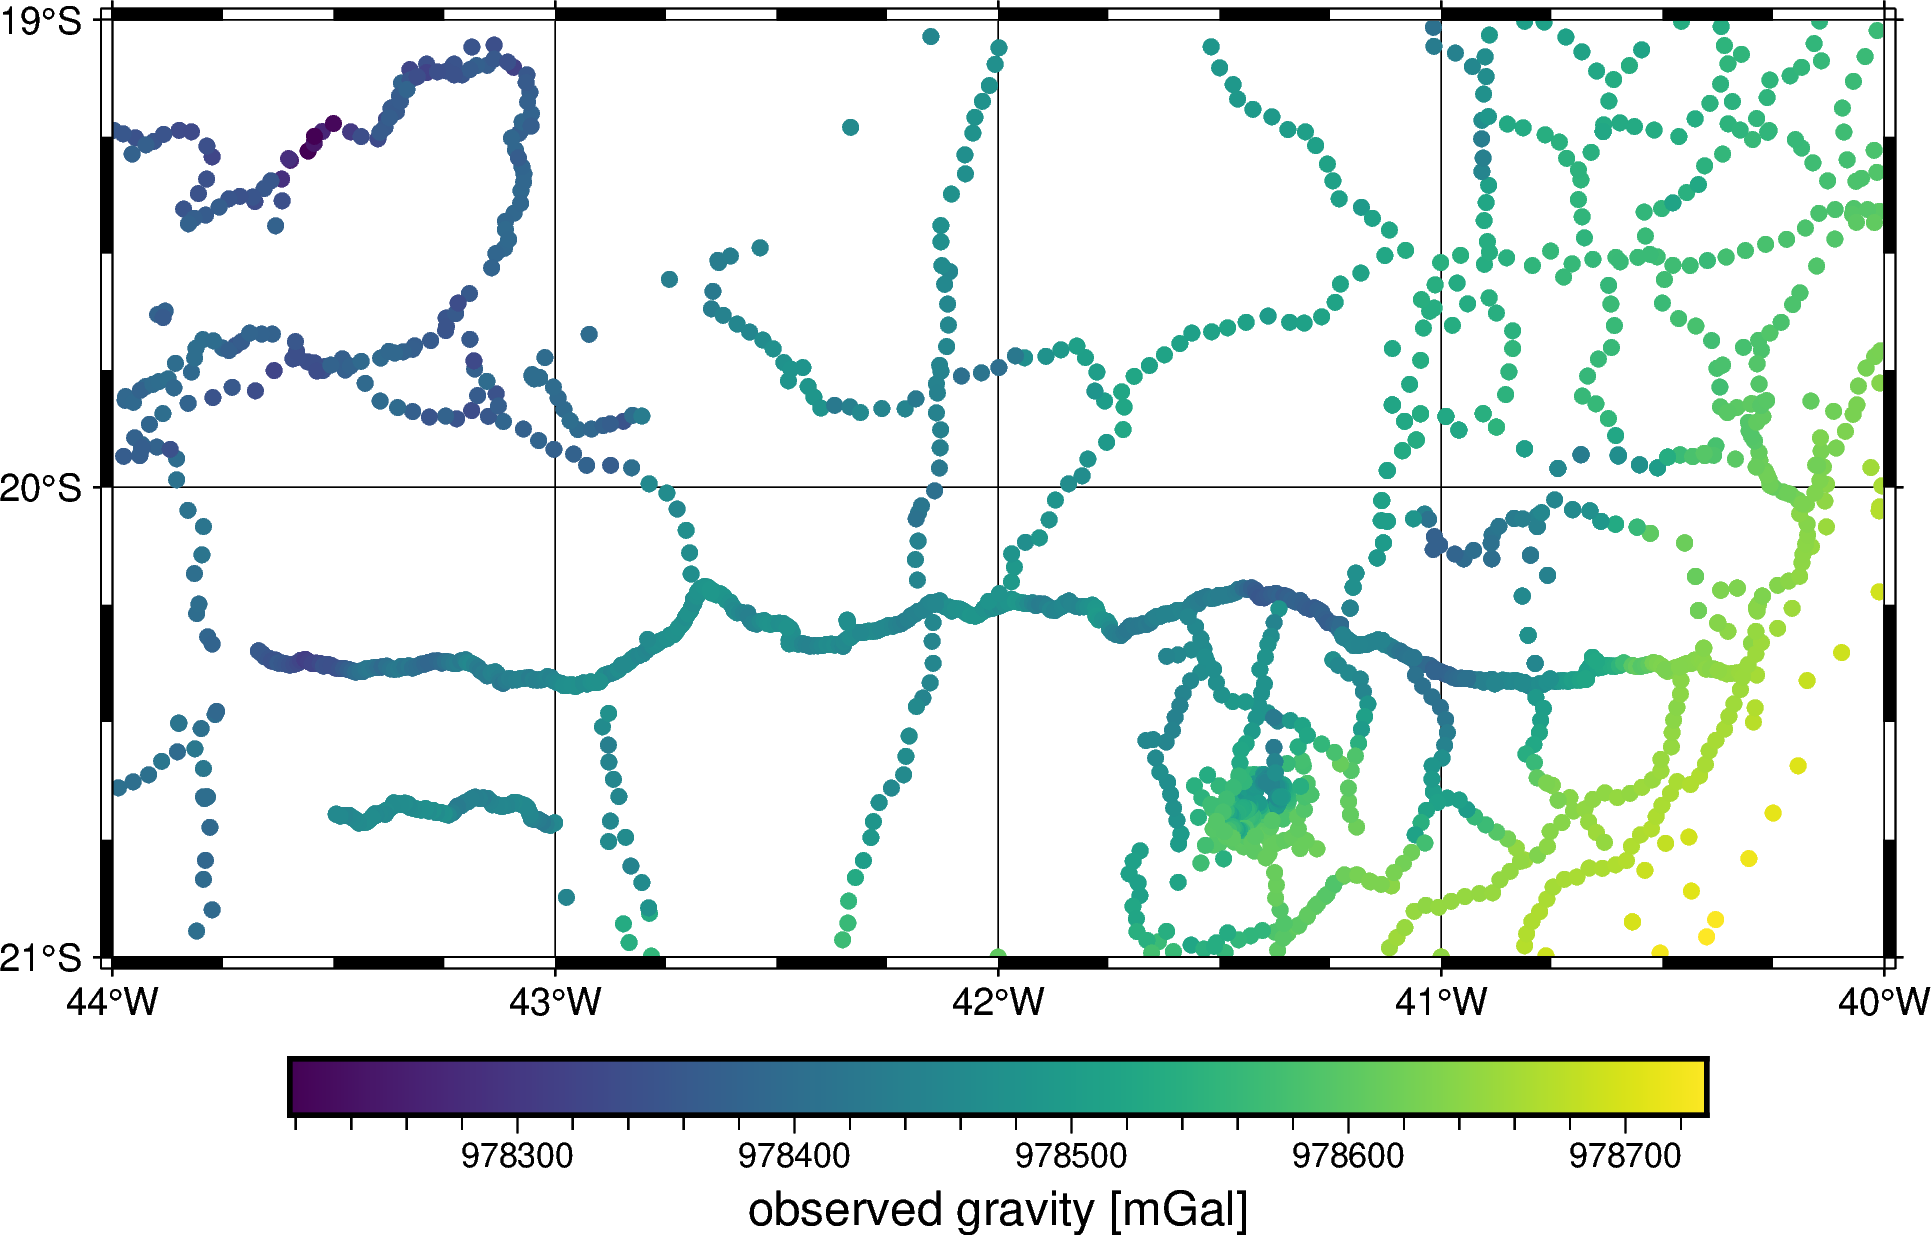

In [11]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame="afg",
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')
fig.show(width=600)

/tmp/ipykernel_36569/1642169547.py:5: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


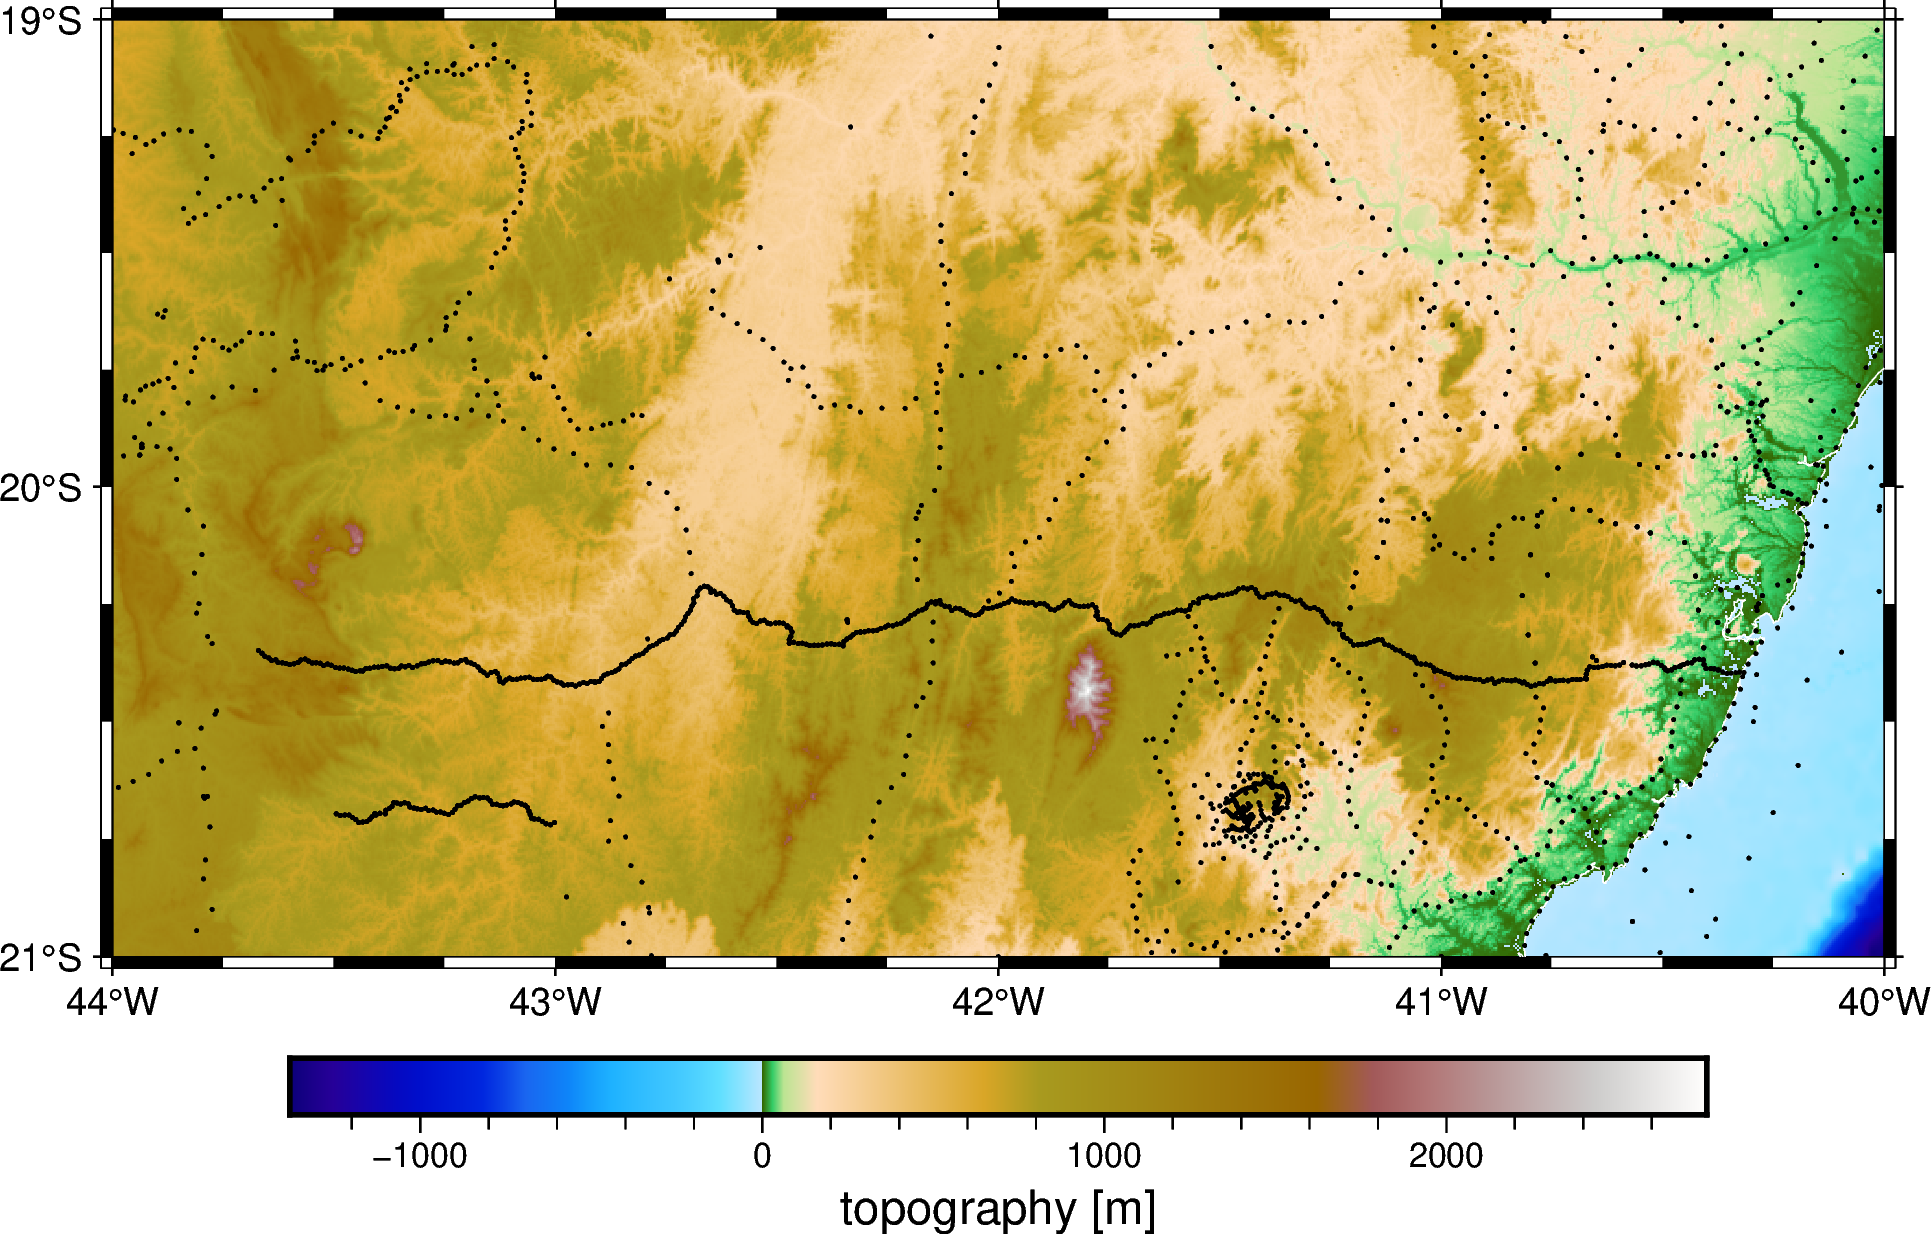

In [12]:
fig = pygmt.Figure()
fig.grdimage(topography_1, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.04c",
    color="black",
)
fig.show(width=600)

## Converte altitudes ortométricas para geométricas

In [13]:
topography_geometric = topography_1 + geoid_1
topography_geometric

<xarray.DataArray (latitude: 480, longitude: 960)>
array([[ 1052.4,  1028.4,  1032.4, ..., -1357. , -1370. , -1388. ],
       [ 1015.4,  1015.4,  1033.4, ..., -1358.5, -1367. , -1379.5],
       [  999.4,  1007.4,  1033.4, ..., -1357. , -1363. , -1371. ],
       ...,
       [  632.7,   659.7,   674.7, ...,    54.4,    54.4,    51.4],
       [  659.7,   652.7,   658.7, ...,    52.4,    55.4,    57.4],
       [  663.7,   644.7,   631.7, ...,    57.4,    54.4,    55.4]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -44.0 -43.99 -43.99 ... -40.01 -40.01 -40.0
  * latitude   (latitude) float64 -21.0 -20.99 -20.99 ... -19.01 -19.01 -19.0

In [14]:
geoid_table = vd.grid_to_table(geoid)
interpolator = vd.KNeighbors()
geoid_table.values.min()
interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.geoid)
data = data.assign(geoid_m=interpolator.predict((data.longitude, data.latitude)))
data = data.assign(height_geometric_m= data.height_sea_level_m + data.geoid_m)

# data['height_sea_level_m'] = pd.to_numeric(data['height_sea_level_m'], errors='coerce')
# data = data.assign(height_geometric_m=data.height_sea_level_m + data.geoid_m)




# data = data.dropna(subset=['height_sea_level_m'])


has_nan = data.height_geometric_m.isnull().any()
print(has_nan)

data


False


Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635   
...             ...           ...        ...        ...            ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000   
3303            NaN           NaN -42.993600 -19.810300  978392.810000   
3306            NaN           NaN -43.054700 -19.228100  978369.810000   
3307            NaN           NaN -43.036900 -19.765800  978398.220000   
3309            NaN           NaN -43.004400 -19.786700  978397.250000   

      TideCorr        Source    geoid_m  height_geometric_m  
0     0.053423  03122019_996  -5.800000          142.140000  
1     0.066119  03122019_996  -5.800000          146.260000  
2     0.077715  03122019_996  -5.600000          111.700000  
3     0.081974  03122019_996  -5.800000          123.300000  
4     0.082319  03122019_996  -5.800000          124.210000  
...        ...           ...        ...                 ...  
3301       NaN          UFOP  -9.000000          555.530000  
3303       NaN          UFOP  -9.000000          552.500000  
3306       NaN          UFOP -10.400001          570.819999  
3307       NaN          UFOP  -9.000000          520.920000  
3309       NaN          UFOP  -9.000000          520.160000  

[2259 rows x 14 columns]

## Distúrbio da gravidade

In [15]:
data = data.assign(
    normal_gravity_mgal=bl.WGS84.normal_gravity(data.latitude, data.height_geometric_m)
)
data = data.assign(gravity_disturbance_mgal=data.gravity_mgal - data.normal_gravity_mgal)
data

/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/boule/_ellipsoid.py:555: UserWarning: Formulas used are valid for points outside the ellipsoid.Height must be greater than or equal to zero.
  warn(


Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635   
...             ...           ...        ...        ...            ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000   
3303            NaN           NaN -42.993600 -19.810300  978392.810000   
3306            NaN           NaN -43.054700 -19.228100  978369.810000   
3307            NaN           NaN -43.036900 -19.765800  978398.220000   
3309            NaN           NaN -43.004400 -19.786700  978397.250000   

      TideCorr        Source    geoid_m  height_geometric_m  \
0     0.053423  03122019_996  -5.800000          142.140000   
1     0.066119  03122019_996  -5.800000          146.260000   
2     0.077715  03122019_996  -5.600000          111.700000   
3     0.081974  03122019_996  -5.800000          123.300000   
4     0.082319  03122019_996  -5.800000          124.210000   
...        ...           ...        ...                 ...   
3301       NaN          UFOP  -9.000000          555.530000   
3303       NaN          UFOP  -9.000000          552.500000   
3306       NaN          UFOP -10.400001          570.819999   
3307       NaN          UFOP  -9.000000          520.920000   
3309       NaN          UFOP  -9.000000          520.160000   

      normal_gravity_mgal  gravity_disturbance_mgal  
0           978637.817634                -46.411029  
1           978636.372087                -44.926310  
2           978646.141191                -47.667672  
3           978643.260610                -45.450731  
4           978643.593922                -41.848287  
...                   ...                       ...  
3301        978457.167166                -57.637166  
3303        978455.303743                -62.493743  
3306        978416.571994                -46.761994  
3307        978462.493467                -64.273467  
3309        978463.928601                -66.678601  

[2259 rows x 16 columns]

/tmp/ipykernel_36569/2682708163.py:4: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


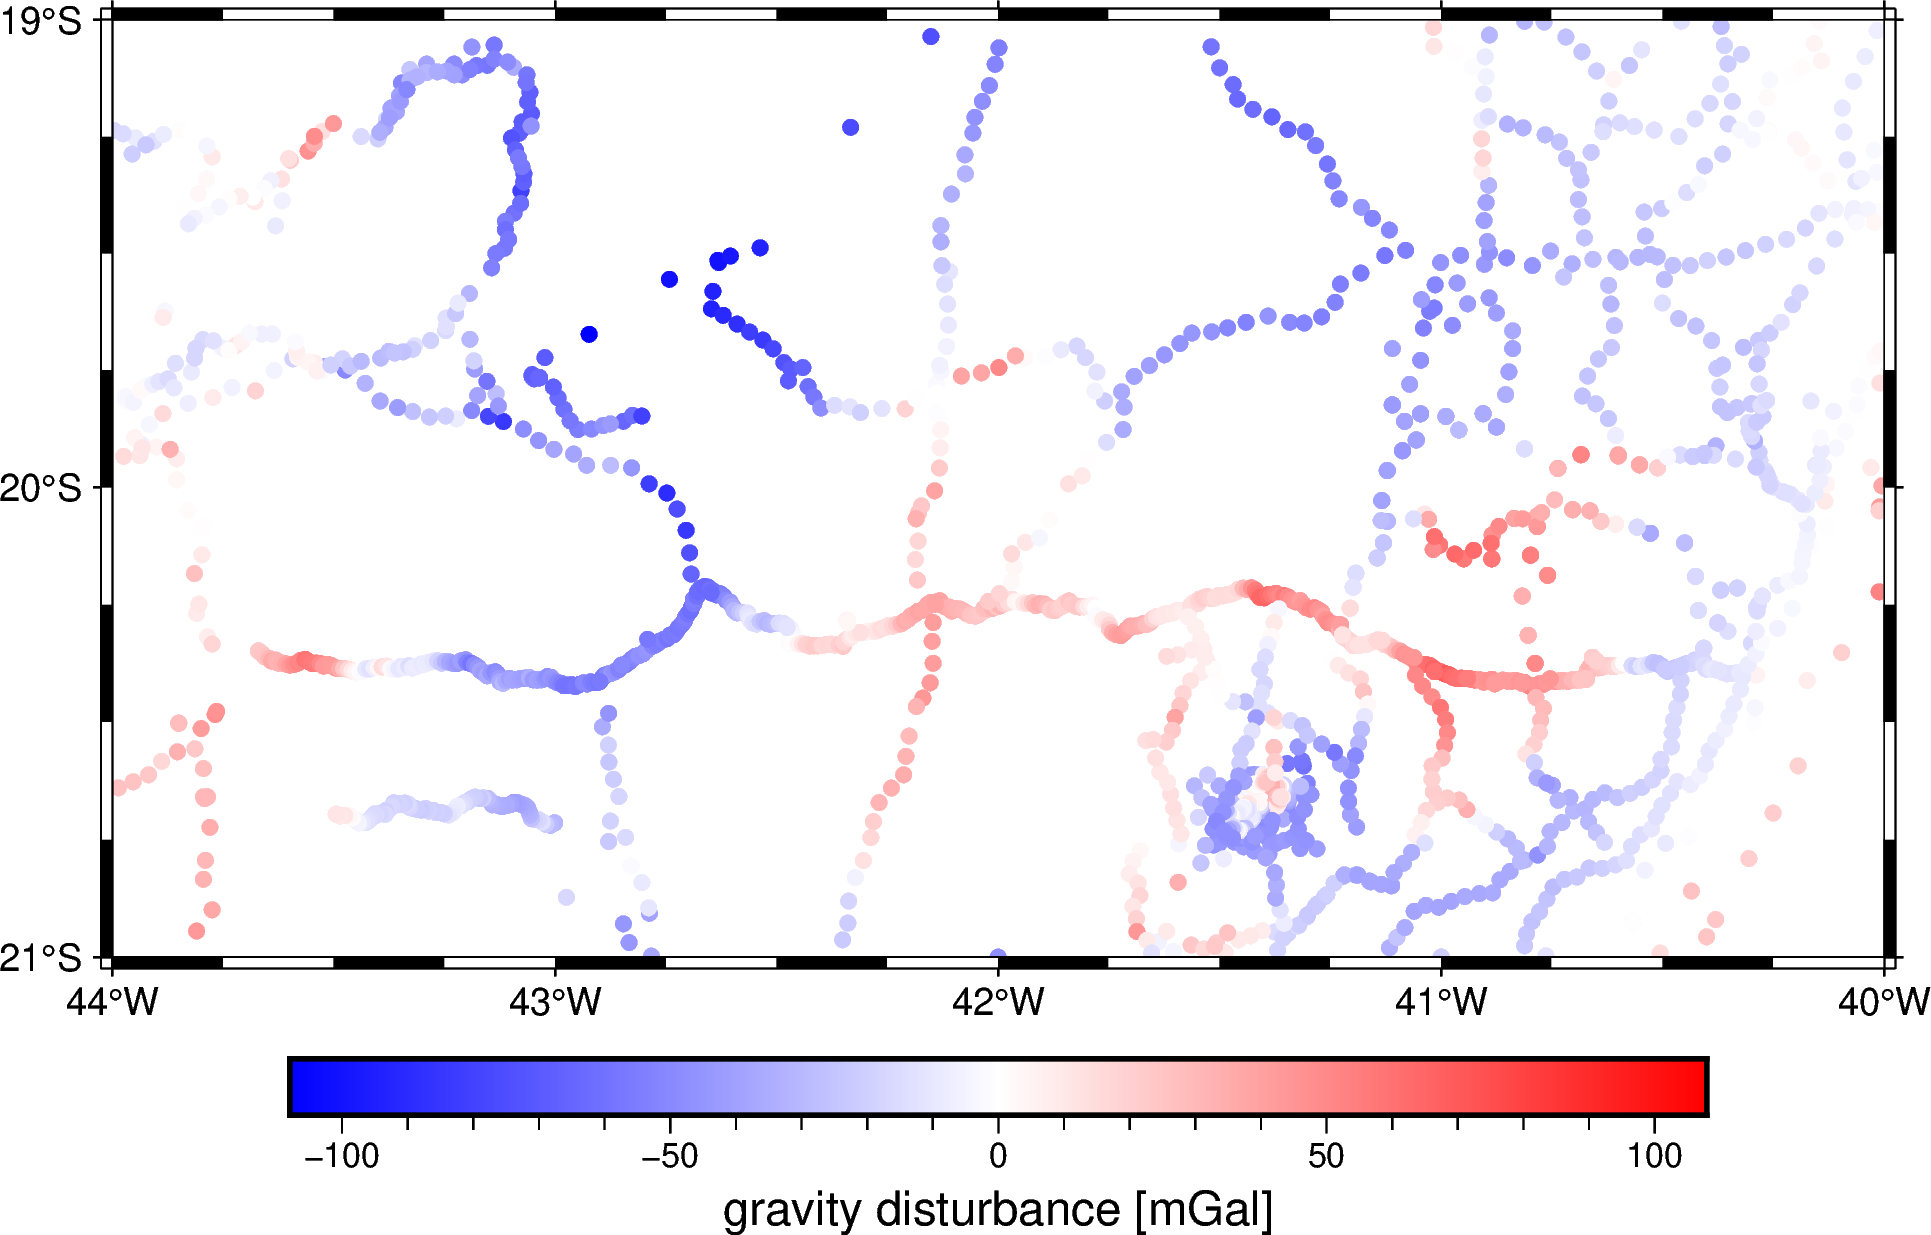

In [16]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame="af",
)
fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show(width=600)

## Correção topográfica

![](https://www.fatiando.org/tutorials/_images/topographic-correction.svg)

In [17]:
# projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

projection = pyproj.Proj(proj='utm', ellps='WGS84', zone=24, south=True)

In [18]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data

Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635   
...             ...           ...        ...        ...            ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000   
3303            NaN           NaN -42.993600 -19.810300  978392.810000   
3306            NaN           NaN -43.054700 -19.228100  978369.810000   
3307            NaN           NaN -43.036900 -19.765800  978398.220000   
3309            NaN           NaN -43.004400 -19.786700  978397.250000   

      TideCorr        Source    geoid_m  height_geometric_m  \
0     0.053423  03122019_996  -5.800000          142.140000   
1     0.066119  03122019_996  -5.800000          146.260000   
2     0.077715  03122019_996  -5.600000          111.700000   
3     0.081974  03122019_996  -5.800000          123.300000   
4     0.082319  03122019_996  -5.800000          124.210000   
...        ...           ...        ...                 ...   
3301       NaN          UFOP  -9.000000          555.530000   
3303       NaN          UFOP  -9.000000          552.500000   
3306       NaN          UFOP -10.400001          570.819999   
3307       NaN          UFOP  -9.000000          520.920000   
3309       NaN          UFOP  -9.000000          520.160000   

      normal_gravity_mgal  gravity_disturbance_mgal      easting_m  \
0           978637.817634                -46.411029  238246.104213   
1           978636.372087                -44.926310  239573.565308   
2           978646.141191                -47.667672  241216.748956   
3           978643.260610                -45.450731  243071.287960   
4           978643.593922                -41.848287  245332.547009   
...                   ...                       ...            ...   
3301        978457.167166                -57.637166   84468.331336   
3303        978455.303743                -62.493743   81487.575887   
3306        978416.571994                -46.761994   73547.459289   
3307        978462.493467                -64.273467   76826.240806   
3309        978463.928601                -66.678601   80292.311699   

        northing_m  
0     7.702141e+06  
1     7.702483e+06  
2     7.704176e+06  
3     7.702906e+06  
4     7.701803e+06  
...            ...  
3301  7.799241e+06  
3303  7.804562e+06  
3306  7.868958e+06  
3307  7.809388e+06  
3309  7.807152e+06  

[2259 rows x 18 columns]

/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/verde/blockreduce.py:177: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  columns = {"data{}".format(i): comp.ravel() for i, comp in enumerate(data)}
/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function mean at 0x7f40c04e7520> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function mean at 0x7f40c04e7520> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callab

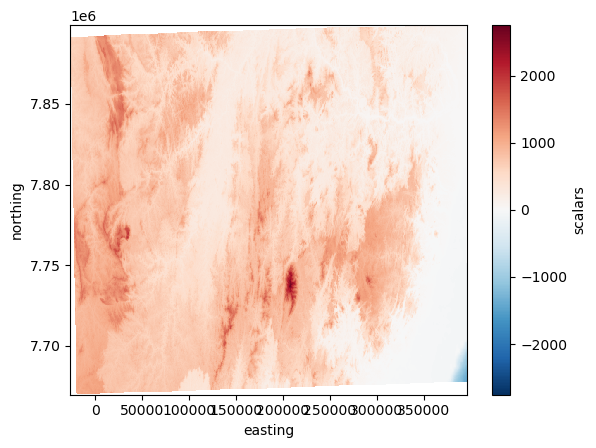

In [19]:
topography_proj = vd.project_grid(topography_geometric, projection, method="nearest")
topography_proj.plot()

In [20]:
topography_density = np.where(topography_proj > 0, 2670, 1040 - 2670)
topography_model = hm.prism_layer(
    coordinates=(topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": topography_density}
)
topography_model

<xarray.Dataset>
Dimensions:   (northing: 480, easting: 960)
Coordinates:
  * easting   (easting) float64 -2.655e+04 -2.611e+04 ... 3.954e+05 3.958e+05
  * northing  (northing) float64 7.67e+06 7.67e+06 ... 7.898e+06 7.899e+06
    top       (northing, easting) float32 nan nan nan nan ... nan nan nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int64 -1630 -1630 -1630 ... -1630 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

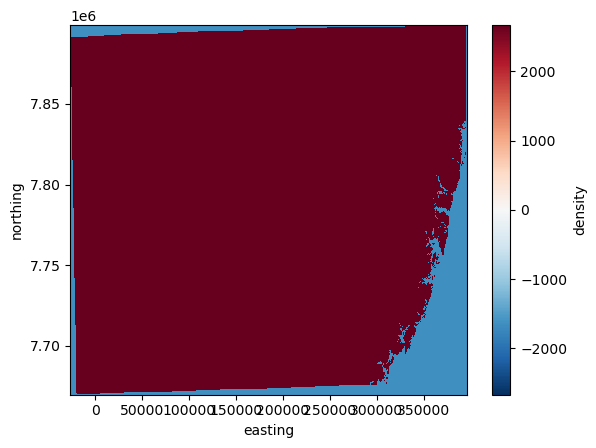

In [21]:
# fig = pygmt.Figure()
# scale = vd.maxabs(topography_model.density)
# pygmt.makecpt(cmap="roma+h", reverse=True, series=[-scale, scale])
# fig.grdimage(topography_model.density, projection="X15c", frame=True)
# fig.colorbar(frame='af+l"Density of the prism model [kg/m3]"')
# fig.show()

topography_model.density.plot()

In [22]:
coordinates = (data.easting_m, data.northing_m, data.height_geometric_m)
terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")

In [23]:
data = data.assign(
    gravity_bouguer_mgal=data.gravity_disturbance_mgal - terrain_effect
)

data = data.dropna(subset=['gravity_bouguer_mgal'])
data

Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635   
...             ...           ...        ...        ...            ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000   
3303            NaN           NaN -42.993600 -19.810300  978392.810000   
3306            NaN           NaN -43.054700 -19.228100  978369.810000   
3307            NaN           NaN -43.036900 -19.765800  978398.220000   
3309            NaN           NaN -43.004400 -19.786700  978397.250000   

      TideCorr        Source    geoid_m  height_geometric_m  \
0     0.053423  03122019_996  -5.800000          142.140000   
1     0.066119  03122019_996  -5.800000          146.260000   
2     0.077715  03122019_996  -5.600000          111.700000   
3     0.081974  03122019_996  -5.800000          123.300000   
4     0.082319  03122019_996  -5.800000          124.210000   
...        ...           ...        ...                 ...   
3301       NaN          UFOP  -9.000000          555.530000   
3303       NaN          UFOP  -9.000000          552.500000   
3306       NaN          UFOP -10.400001          570.819999   
3307       NaN          UFOP  -9.000000          520.920000   
3309       NaN          UFOP  -9.000000          520.160000   

      normal_gravity_mgal  gravity_disturbance_mgal      easting_m  \
0           978637.817634                -46.411029  238246.104213   
1           978636.372087                -44.926310  239573.565308   
2           978646.141191                -47.667672  241216.748956   
3           978643.260610                -45.450731  243071.287960   
4           978643.593922                -41.848287  245332.547009   
...                   ...                       ...            ...   
3301        978457.167166                -57.637166   84468.331336   
3303        978455.303743                -62.493743   81487.575887   
3306        978416.571994                -46.761994   73547.459289   
3307        978462.493467                -64.273467   76826.240806   
3309        978463.928601                -66.678601   80292.311699   

        northing_m  gravity_bouguer_mgal  
0     7.702141e+06            -52.595056  
1     7.702483e+06            -56.325704  
2     7.704176e+06            -56.186797  
3     7.702906e+06            -50.146925  
4     7.701803e+06            -51.863661  
...            ...                   ...  
3301  7.799241e+06           -111.943666  
3303  7.804562e+06           -122.643154  
3306  7.868958e+06           -109.226077  
3307  7.809388e+06           -119.165942  
3309  7.807152e+06           -118.934597  

[2259 rows x 19 columns]

/tmp/ipykernel_36569/2523183884.py:4: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


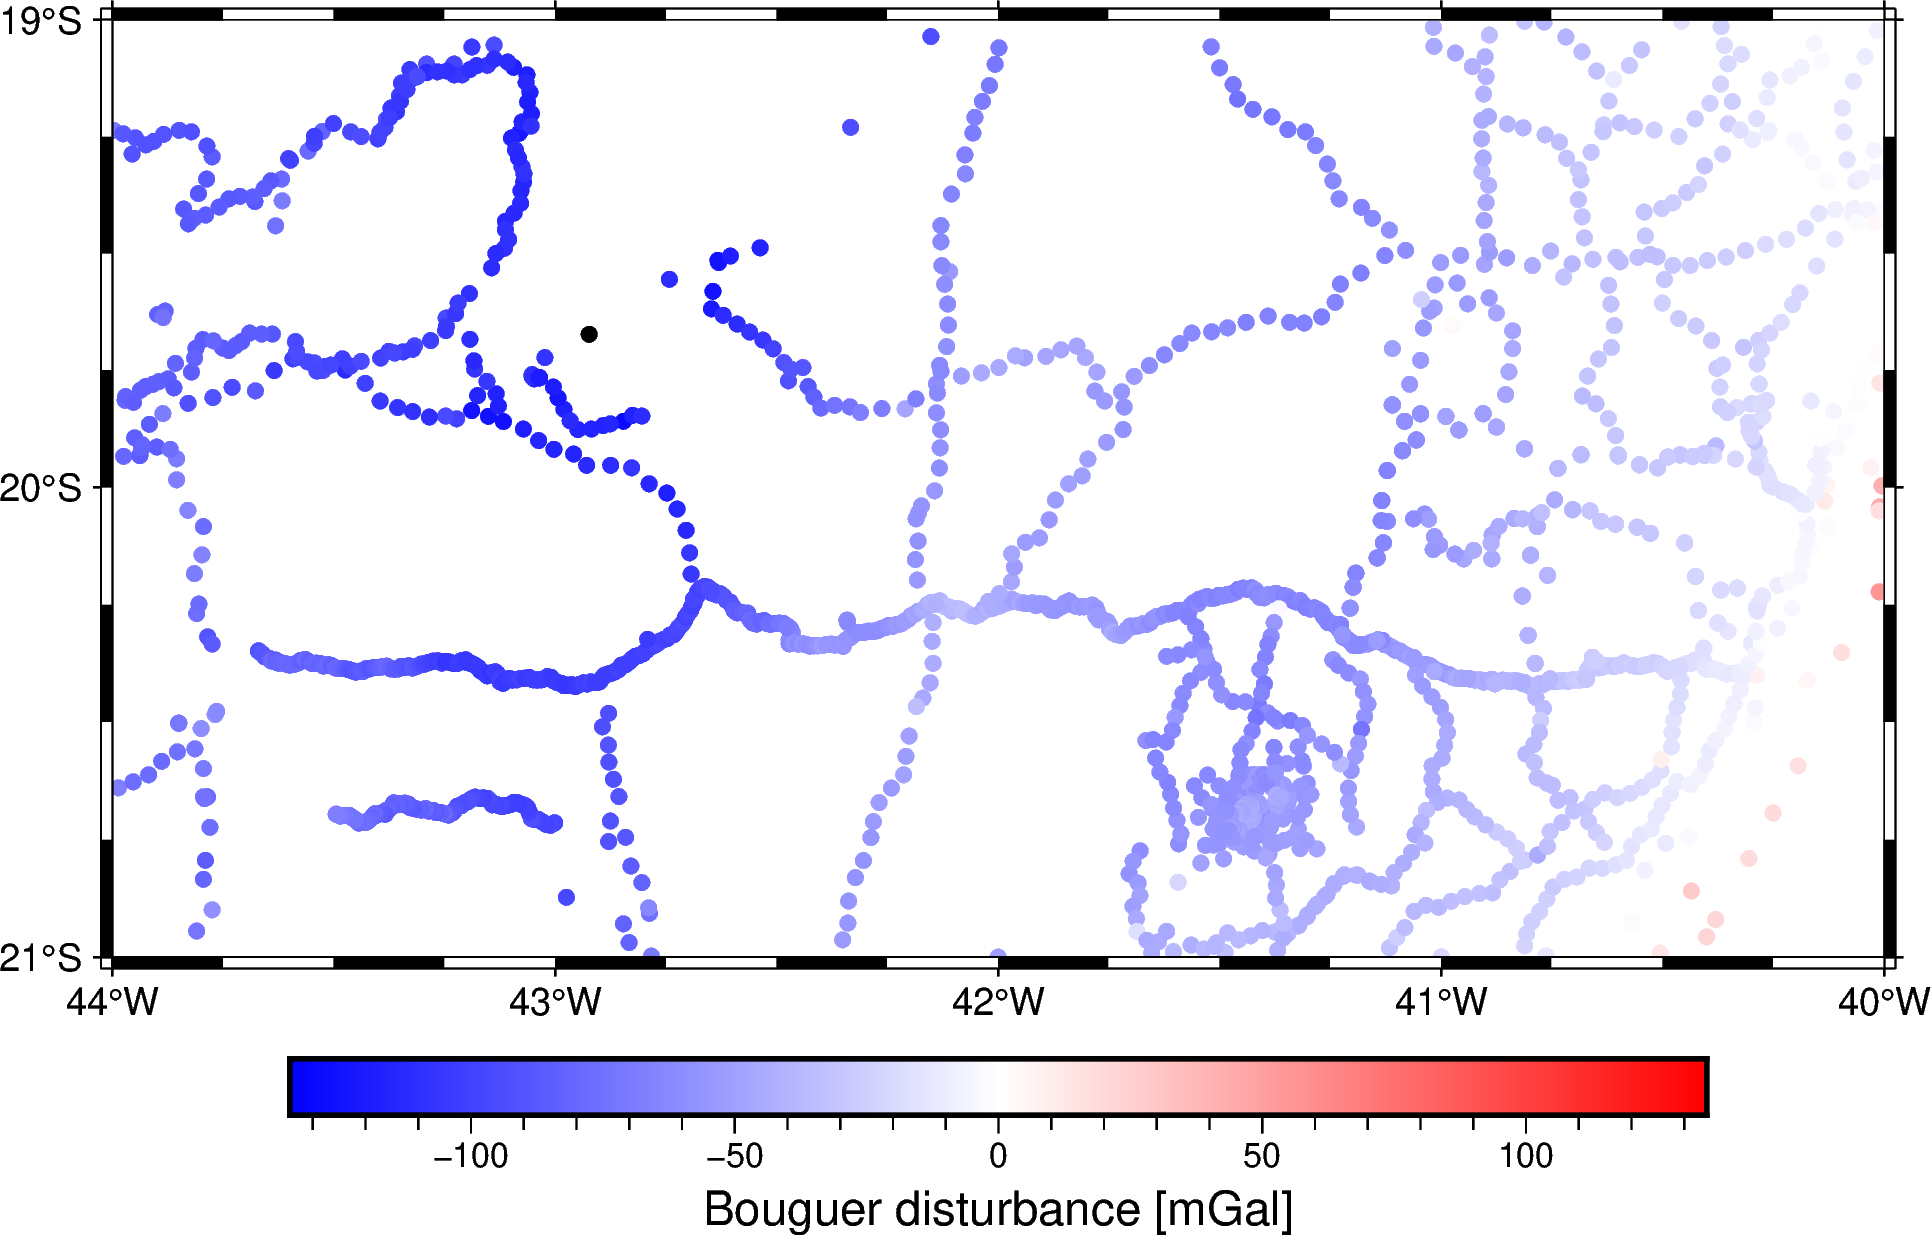

In [24]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_bouguer_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.show()

## Separação regional residual

In [25]:
regional = vd.Trend(degree=3).fit(coordinates, data.gravity_bouguer_mgal)
data = data.assign(
    regional_mgal=regional.predict(coordinates),
)
data = data.assign(
    residual_mgal=data.gravity_bouguer_mgal - data.regional_mgal,
)
data

/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/verde/base/least_squares.py:68: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr.fit(jacobian, data.ravel(), sample_weight=weights)


Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  ...  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605  ...   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776  ...   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518  ...   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879  ...   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635  ...   
...             ...           ...        ...        ...            ...  ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000  ...   
3303            NaN           NaN -42.993600 -19.810300  978392.810000  ...   
3306            NaN           NaN -43.054700 -19.228100  978369.810000  ...   
3307            NaN           NaN -43.036900 -19.765800  978398.220000  ...   
3309            NaN           NaN -43.004400 -19.786700  978397.250000  ...   

            Source    geoid_m  height_geometric_m  normal_gravity_mgal  \
0     03122019_996  -5.800000          142.140000        978637.817634   
1     03122019_996  -5.800000          146.260000        978636.372087   
2     03122019_996  -5.600000          111.700000        978646.141191   
3     03122019_996  -5.800000          123.300000        978643.260610   
4     03122019_996  -5.800000          124.210000        978643.593922   
...            ...        ...                 ...                  ...   
3301          UFOP  -9.000000          555.530000        978457.167166   
3303          UFOP  -9.000000          552.500000        978455.303743   
3306          UFOP -10.400001          570.819999        978416.571994   
3307          UFOP  -9.000000          520.920000        978462.493467   
3309          UFOP  -9.000000          520.160000        978463.928601   

      gravity_disturbance_mgal      easting_m    northing_m  \
0                   -46.411029  238246.104213  7.702141e+06   
1                   -44.926310  239573.565308  7.702483e+06   
2                   -47.667672  241216.748956  7.704176e+06   
3                   -45.450731  243071.287960  7.702906e+06   
4                   -41.848287  245332.547009  7.701803e+06   
...                        ...            ...           ...   
3301                -57.637166   84468.331336  7.799241e+06   
3303                -62.493743   81487.575887  7.804562e+06   
3306                -46.761994   73547.459289  7.868958e+06   
3307                -64.273467   76826.240806  7.809388e+06   
3309                -66.678601   80292.311699  7.807152e+06   

      gravity_bouguer_mgal  regional_mgal  residual_mgal  
0               -52.595056     -51.396760      -1.198296  
1               -56.325704     -51.058492      -5.267212  
2               -56.186797     -50.882685      -5.304112  
3               -50.146925     -50.066781      -0.080144  
4               -51.863661     -49.148007      -2.715654  
...                    ...            ...            ...  
3301           -111.943666     -91.226630     -20.717036  
3303           -122.643154     -91.846757     -30.796397  
3306           -109.226077    -100.845699      -8.380379  
3307           

/tmp/ipykernel_36569/1801782014.py:4: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


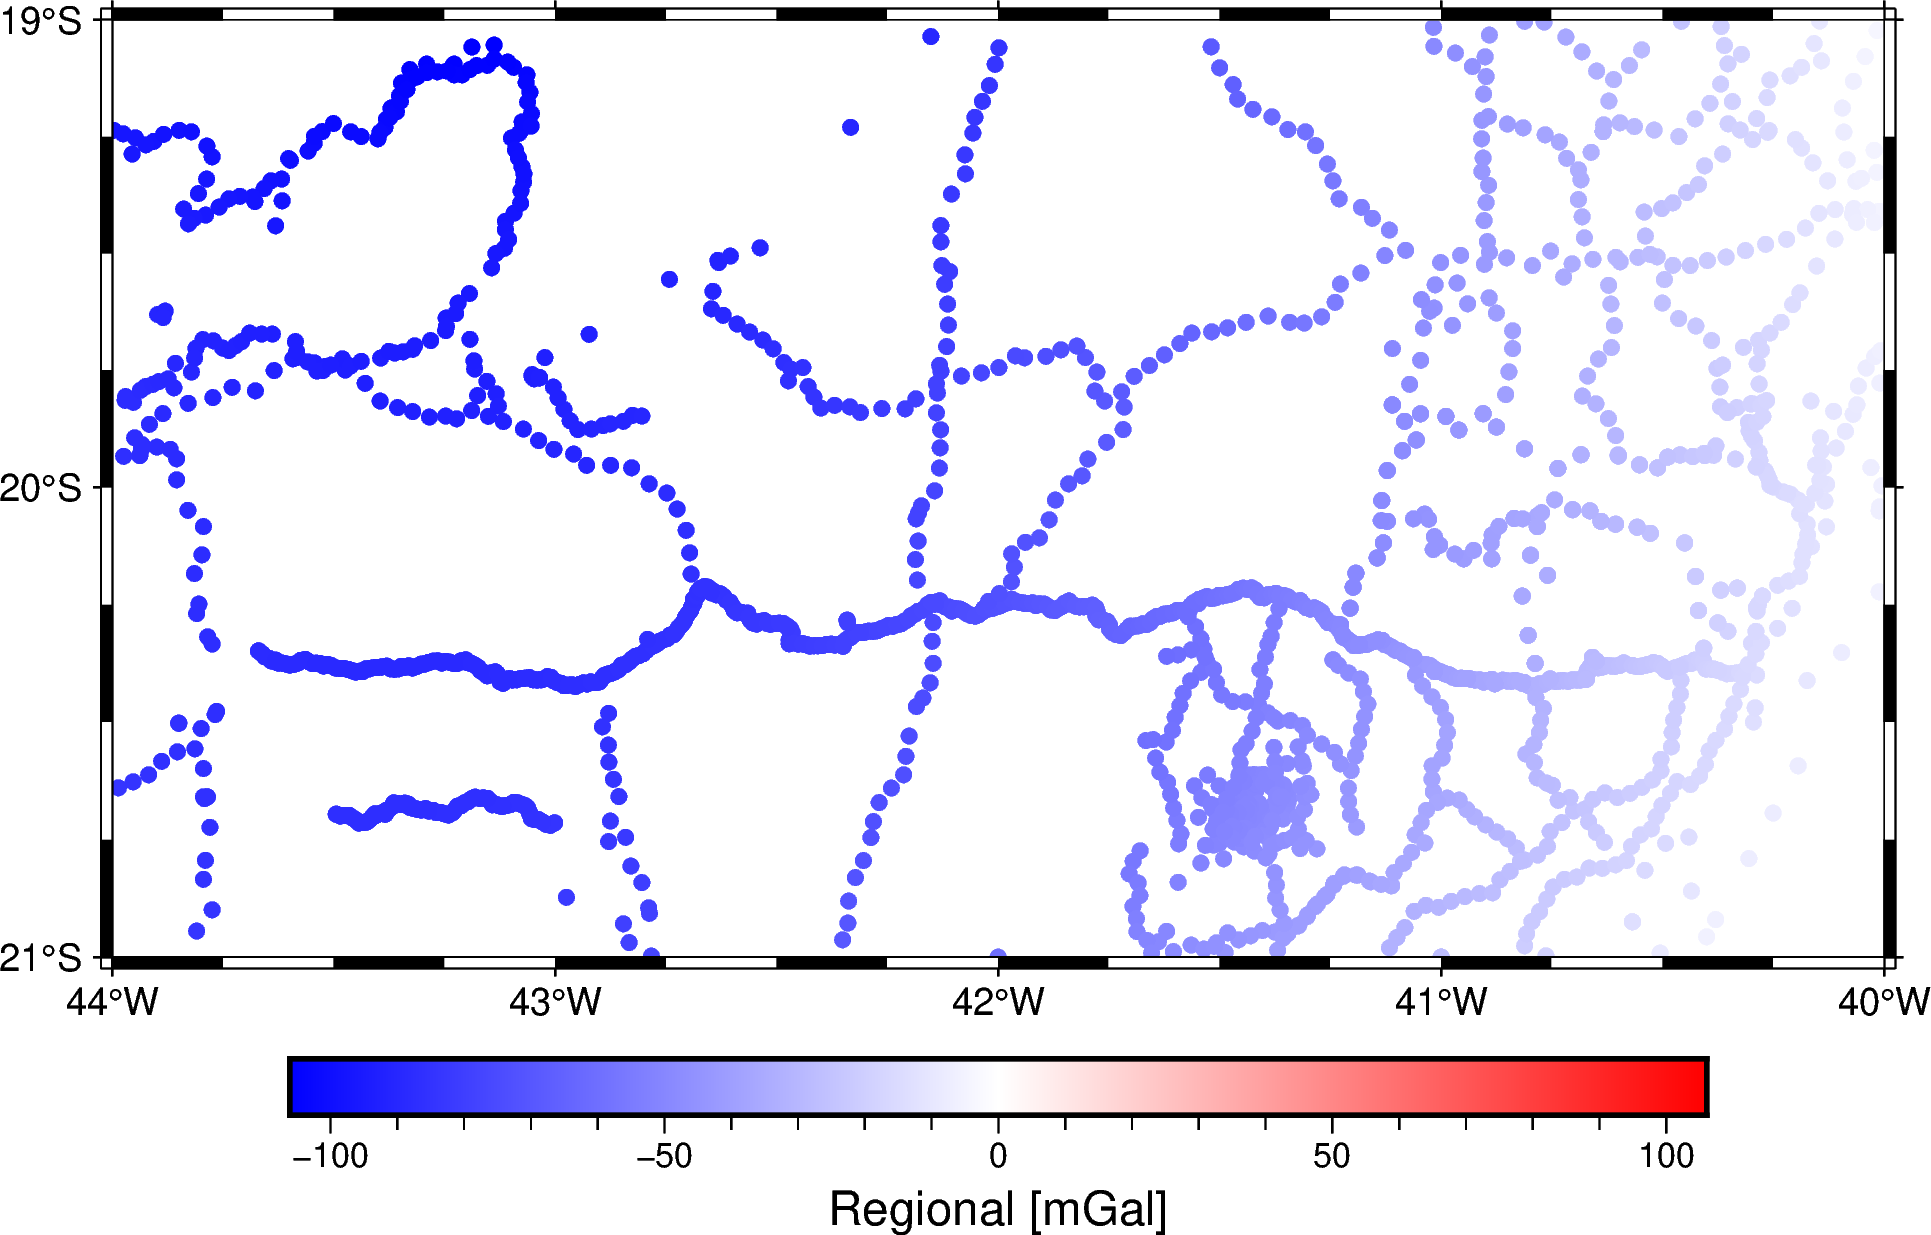

In [26]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.regional_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.regional_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Regional [mGal]"')
fig.show()

/tmp/ipykernel_36569/2252196006.py:4: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


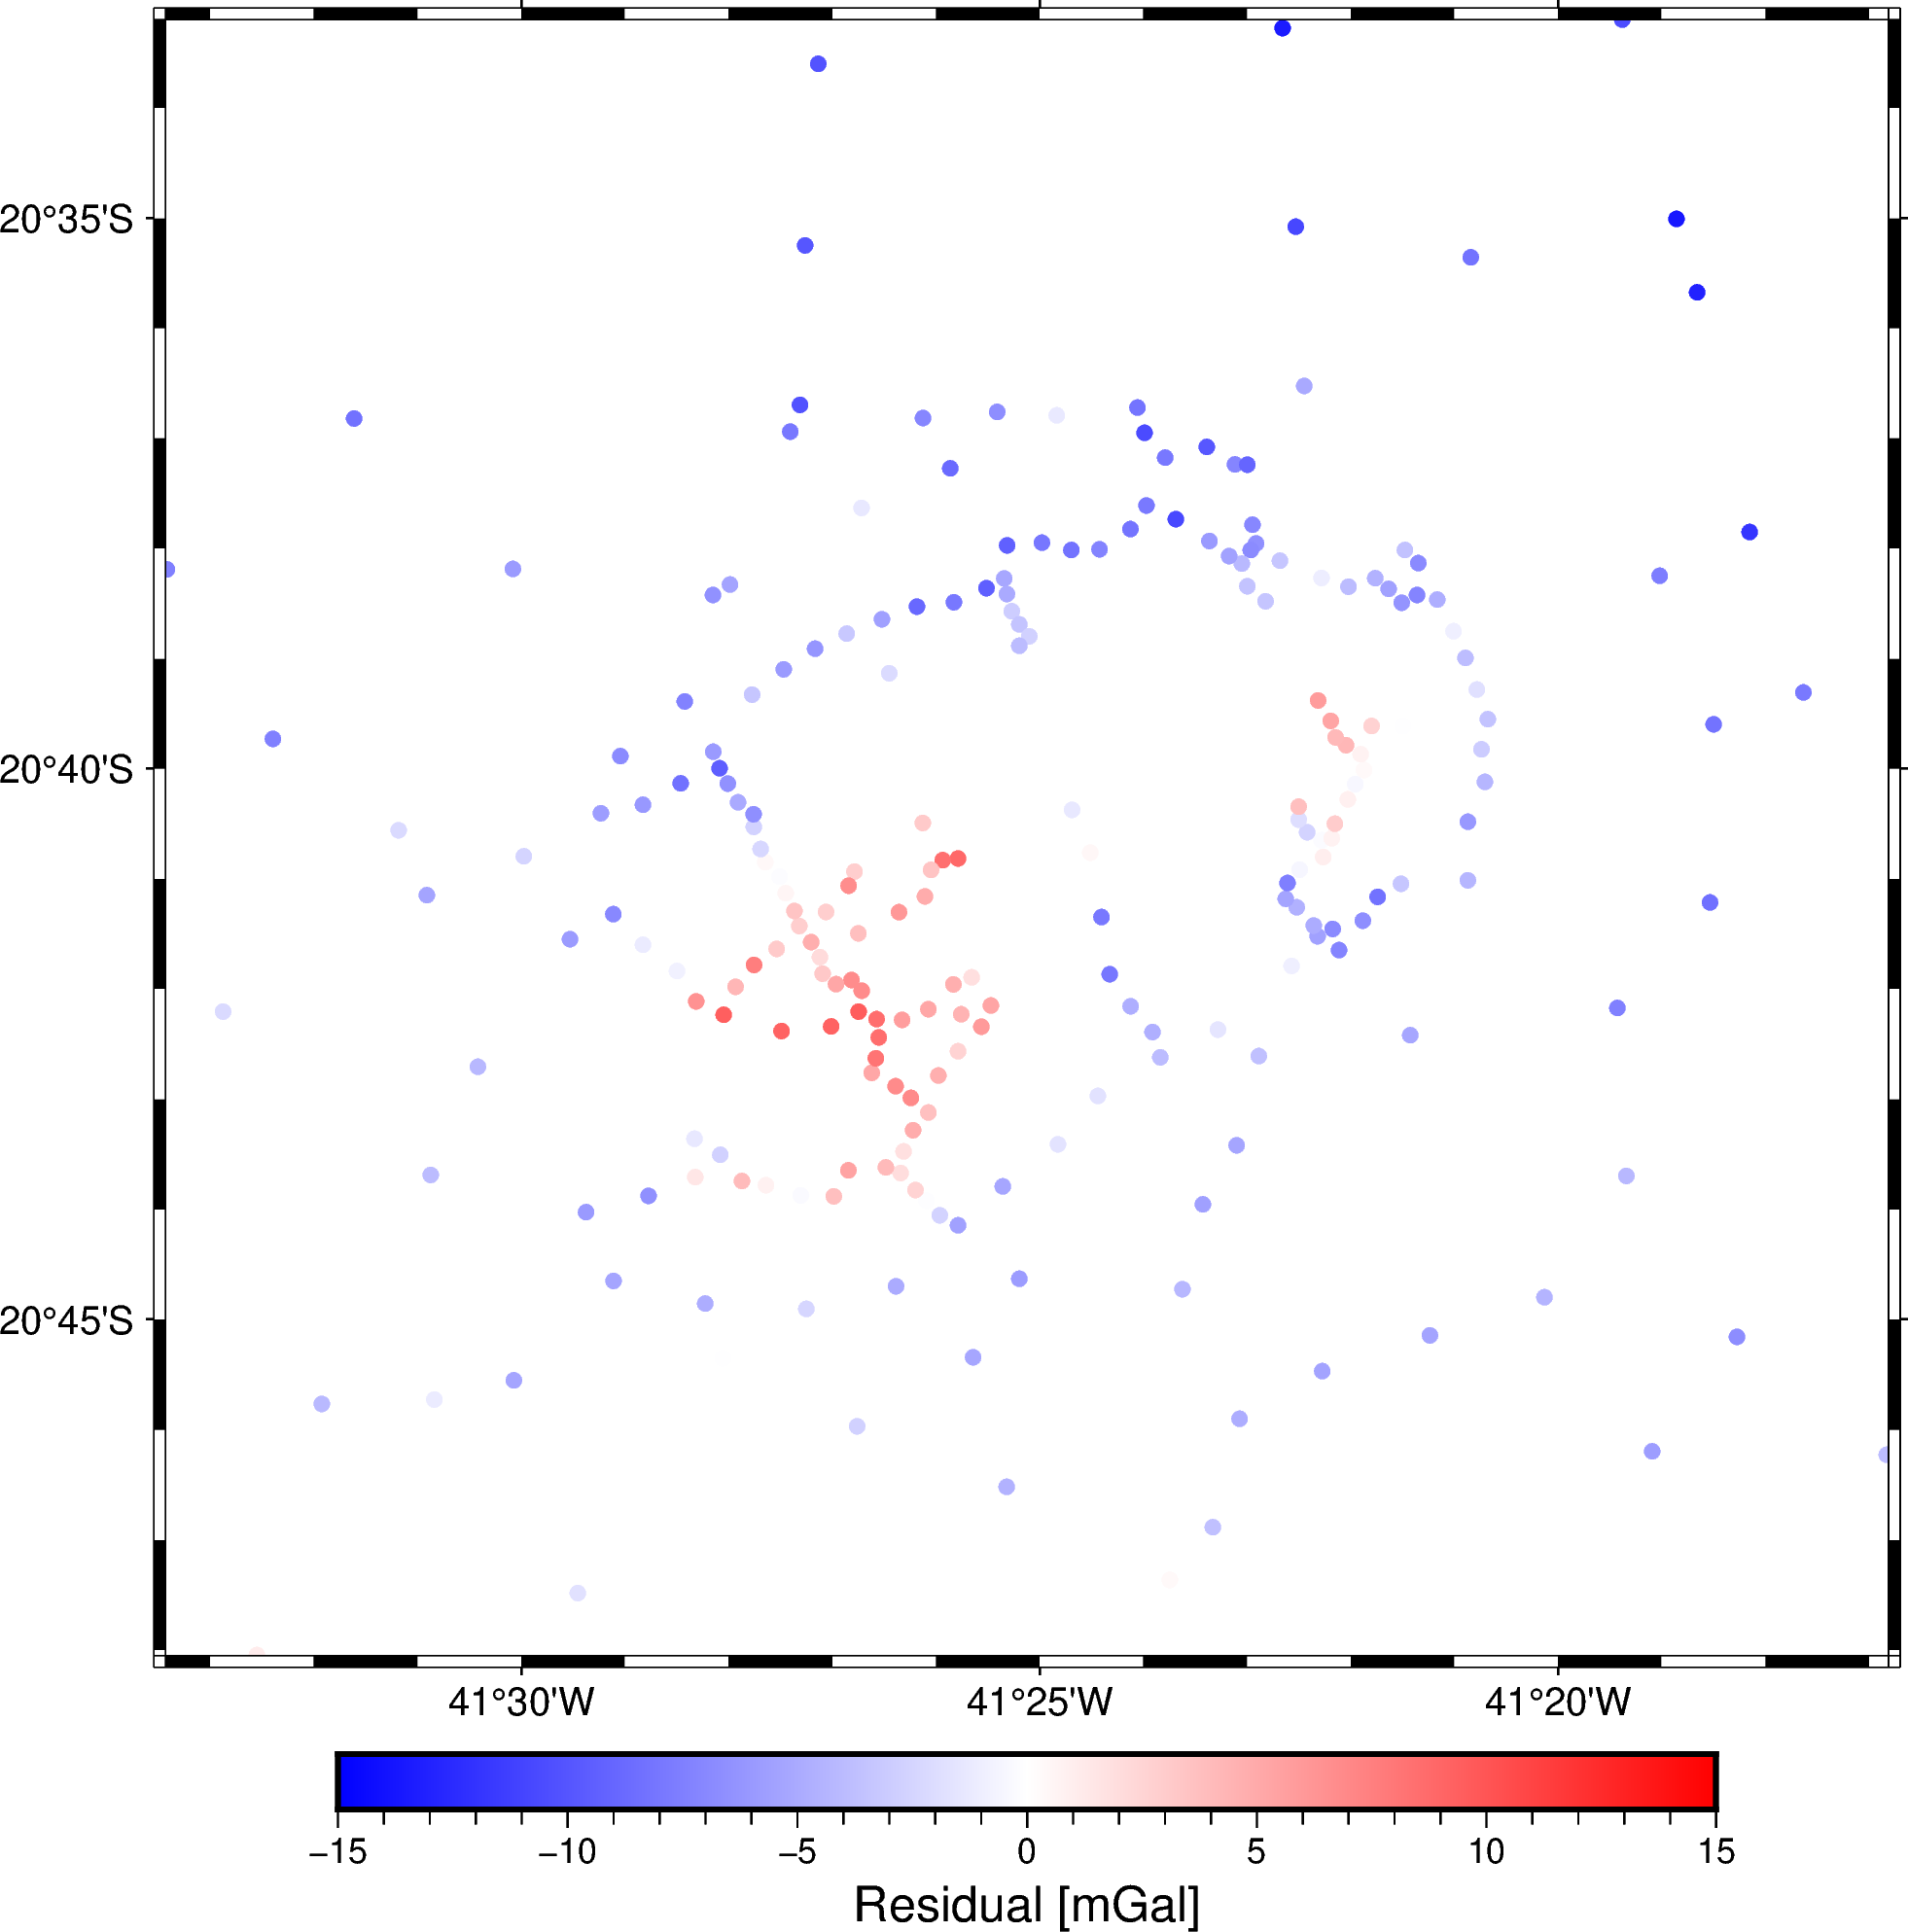

In [27]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.residual_mgal)
pygmt.makecpt(cmap="polar", series=[-15, 15])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.residual_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
    region=(-41.5572222222, -41.2802777778, -20.8008333333, -20.5533333333)
)
fig.colorbar(frame='af+l"Residual [mGal]"')
fig.show()

## Interpolação com fontes equivalentes

In [28]:
eqs = hm.EquivalentSources(damping=10, depth=10e3)
eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m), data.residual_mgal)

/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/verde/base/least_squares.py:68: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr.fit(jacobian, data.ravel(), sample_weight=weights)


EquivalentSources(damping=10, depth=10000.0)

In [29]:
residual_grid = eqs.grid(
    coordinates=vd.grid_coordinates(region, spacing= 4 / 3600, extra_coords=3e3),
    data_names="gravity_residual",
    dims=("latitude", "longitude"),
    projection=projection,
)
residual_grid

<xarray.Dataset>
Dimensions:           (latitude: 1801, longitude: 3601)
Coordinates:
  * longitude         (longitude) float64 -44.0 -44.0 -44.0 ... -40.0 -40.0
  * latitude          (latitude) float64 -21.0 -21.0 -21.0 ... -19.0 -19.0 -19.0
    upward            (latitude, longitude) float64 3e+03 3e+03 ... 3e+03 3e+03
Data variables:
    gravity_residual  (latitude, longitude) float64 7.222 7.237 ... -0.8306
Attributes:
    metadata:  Generated by EquivalentSources(damping=10, depth=10000.0)

/tmp/ipykernel_36569/2216497913.py:12: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


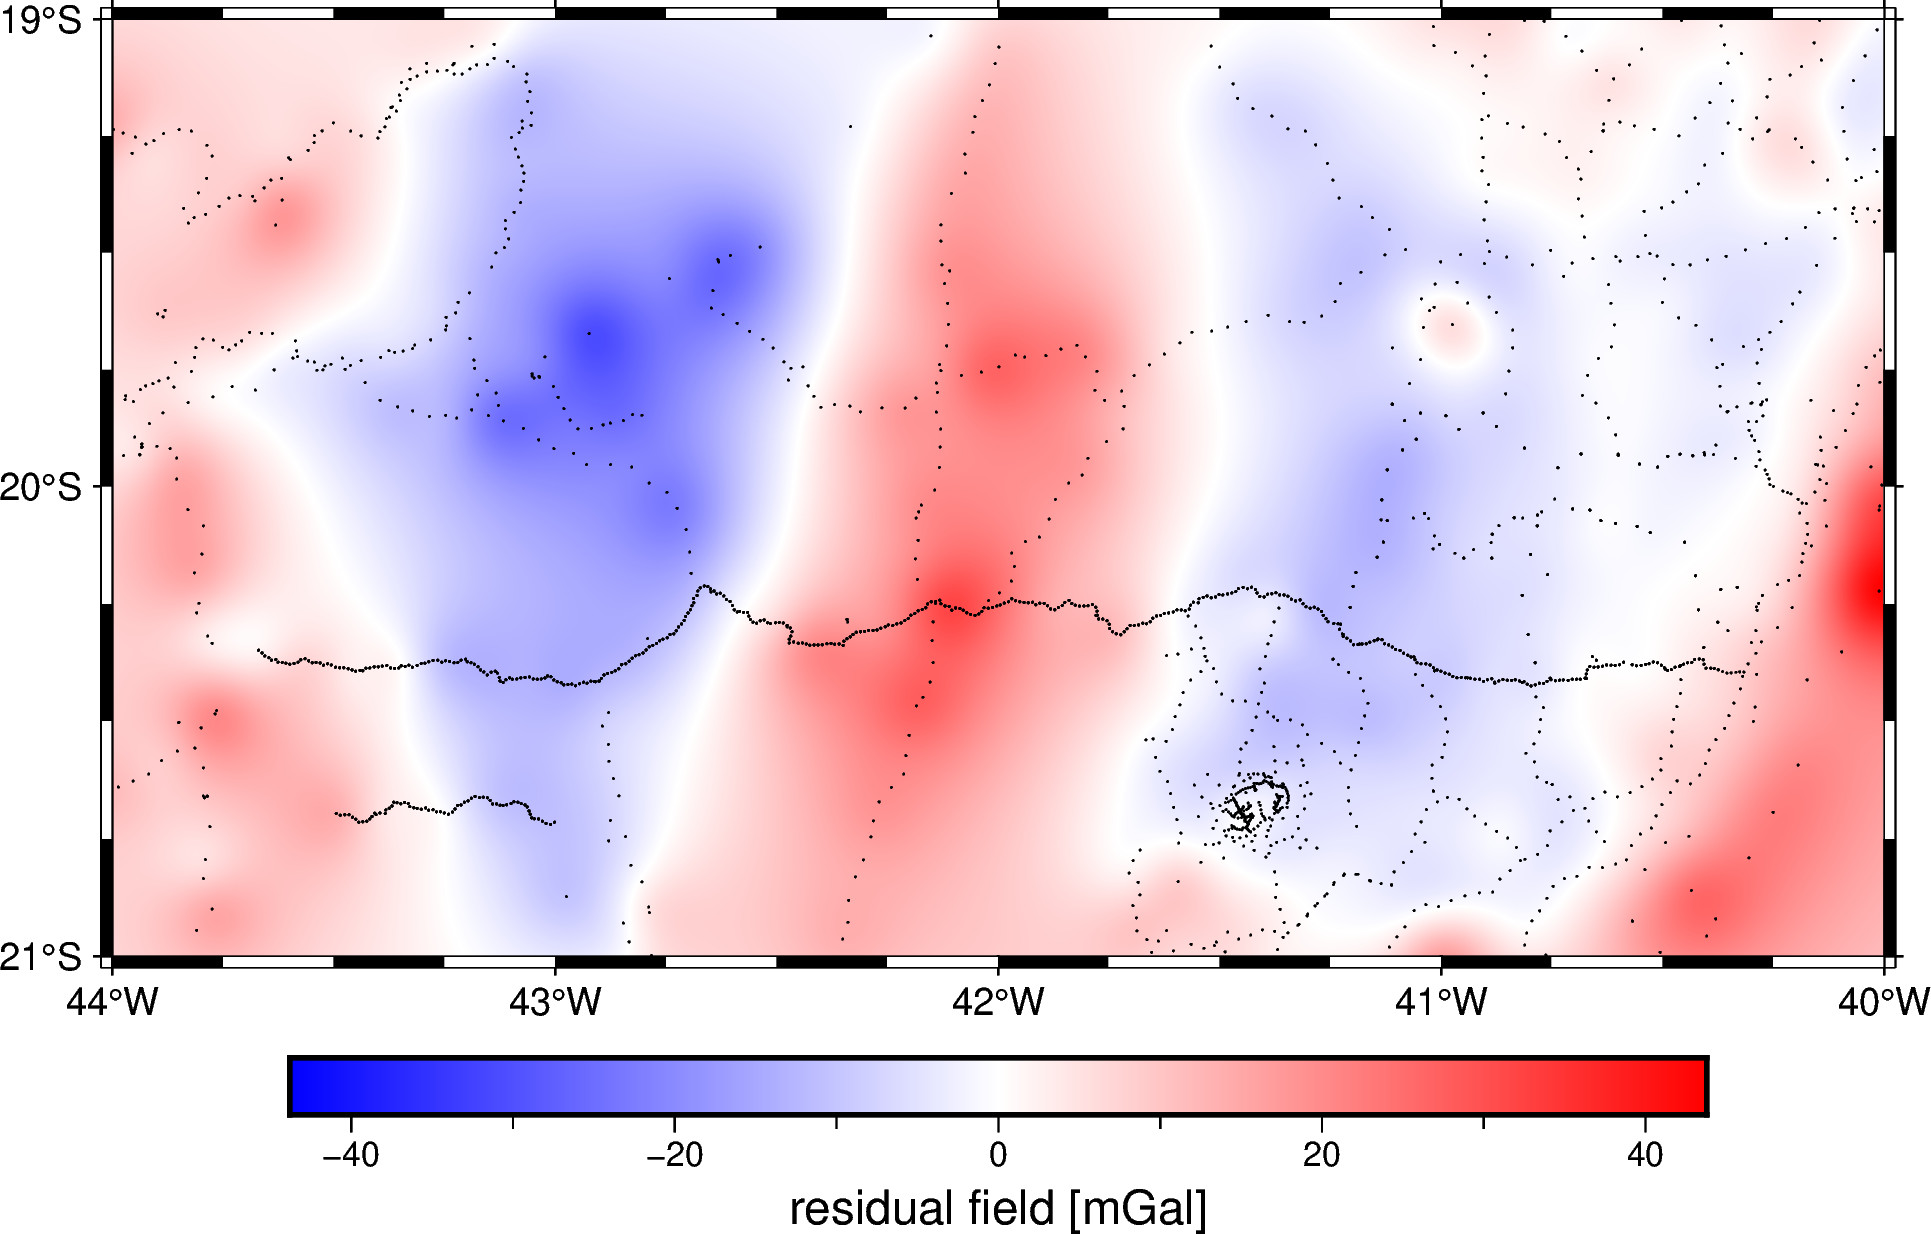

In [30]:
fig = pygmt.Figure()
scale = vd.maxabs(residual_grid.gravity_residual)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    residual_grid.gravity_residual,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    # region=(-41.5572222222, -41.2802777778, -20.8008333333, -20.5533333333)
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.02c",
    color="black",
    
)
fig.show()

Exemplo de figura

<!-- ![](https://www.fatiando.org/tutorials/_images/bushveld_igneous_complex_geology.jpg) -->

# Grid Low Frequency Residual 

In [39]:
interpolator = vd.KNeighbors()
# interpolator.fit((residual_grid.longitude, residual_grid.latitude), residual_grid.gravity_residual)
interpolator.fit(vd.grid_coordinates(region, spacing= 4 / 3600), residual_grid.gravity_residual)

data = data.assign(low_freq_residual=interpolator.predict((data.longitude, data.latitude)))

# Obs - low frequency
data = data.assign(obs_minus_low_freq_residual=data.residual_mgal-data.low_freq_residual)

data


Station  Reading      Time        Date  height_sea_level_m  \
0          1  2239.39  14:28:00  2019/12/03              147.94   
1          2  2239.41  15:12:00  2019/12/03              152.06   
2          3  2246.38  16:06:00  2019/12/03              117.30   
3          4  2245.71  16:46:00  2019/12/03              129.10   
4          5  2249.62  17:13:00  2019/12/03              130.01   
...      ...      ...       ...         ...                 ...   
3301      na      NaN       NaN         NaN              564.53   
3303      na      NaN       NaN         NaN              561.50   
3306      na      NaN       NaN         NaN              581.22   
3307      na      NaN       NaN         NaN              529.92   
3309      na      NaN       NaN         NaN              529.16   

                  X             Y  longitude   latitude   gravity_mgal  ...  \
0     238246.104213  7.702141e+06 -41.514018 -20.762135  978591.406605  ...   
1     239573.565307  7.702483e+06 -41.501226 -20.759230  978591.445776  ...   
2     241216.748955  7.704176e+06 -41.485206 -20.744179  978598.473518  ...   
3     243071.287960  7.702906e+06 -41.467595 -20.755897  978597.809879  ...   
4     245332.547009  7.701803e+06 -41.446052 -20.766168  978601.745635  ...   
...             ...           ...        ...        ...            ...  ...   
3301            NaN           NaN -42.966400 -19.858900  978399.530000  ...   
3303            NaN           NaN -42.993600 -19.810300  978392.810000  ...   
3306            NaN           NaN -43.054700 -19.228100  978369.810000  ...   
3307            NaN           NaN -43.036900 -19.765800  978398.220000  ...   
3309            NaN           NaN -43.004400 -19.786700  978397.250000  ...   

      height_geometric_m normal_gravity_mgal  gravity_disturbance_mgal  \
0             142.140000       978637.817634                -46.411029   
1             146.260000       978636.372087                -44.926310   
2             111.700000       978646.141191                -47.667672   
3             123.300000       978643.260610                -45.450731   
4             124.210000       978643.593922                -41.848287   
...                  ...                 ...                       ...   
3301          555.530000       978457.167166                -57.637166   
3303          552.500000       978455.303743                -62.493743   
3306          570.819999       978416.571994                -46.761994   
3307          520.920000       978462.493467                -64.273467   
3309          520.160000       978463.928601                -66.678601   

          easting_m    northing_m  gravity_bouguer_mgal  regional_mgal  \
0     238246.104213  7.702141e+06            -52.595056     -51.396760   
1     239573.565308  7.702483e+06            -56.325704     -51.058492   
2     241216.748956  7.704176e+06            -56.186797     -50.882685   
3     243071.287960  7.702906e+06            -50.146925     -50.066781   
4     245332.547009  7.701803e+06            -51.863661     -49.148007   
...             ...           ...                   ...            ...   
3301   84468.331336  7.799241e+06           -111.943666     -91.226630   
3303   81487.575887  7.804562e+06           -122.643154     -91.846757   
3306   73547.459289  7.868958e+06           -109.226077    -100.845699   
3307   76826.240806  7.809388e+06           -119.165942     -92.542437   
3309   80292.311699  7.807152e+06           -118.934597     -92.137135   

      residual_mgal  low_freq_residual  obs_minus_low_freq_residual  
0         -1.198296          -1.001932                    -0.196364  
1         -5.267212          -1.223004                    -4.044208  
2         -5.304112          -1.290348                    -4.013764  
3         -0.080144          -1.202177                     1.122032  
4         -2.715654          -1.592887                    -1.122766  
...             ...                ...               

/tmp/ipykernel_36569/2248006814.py:4: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


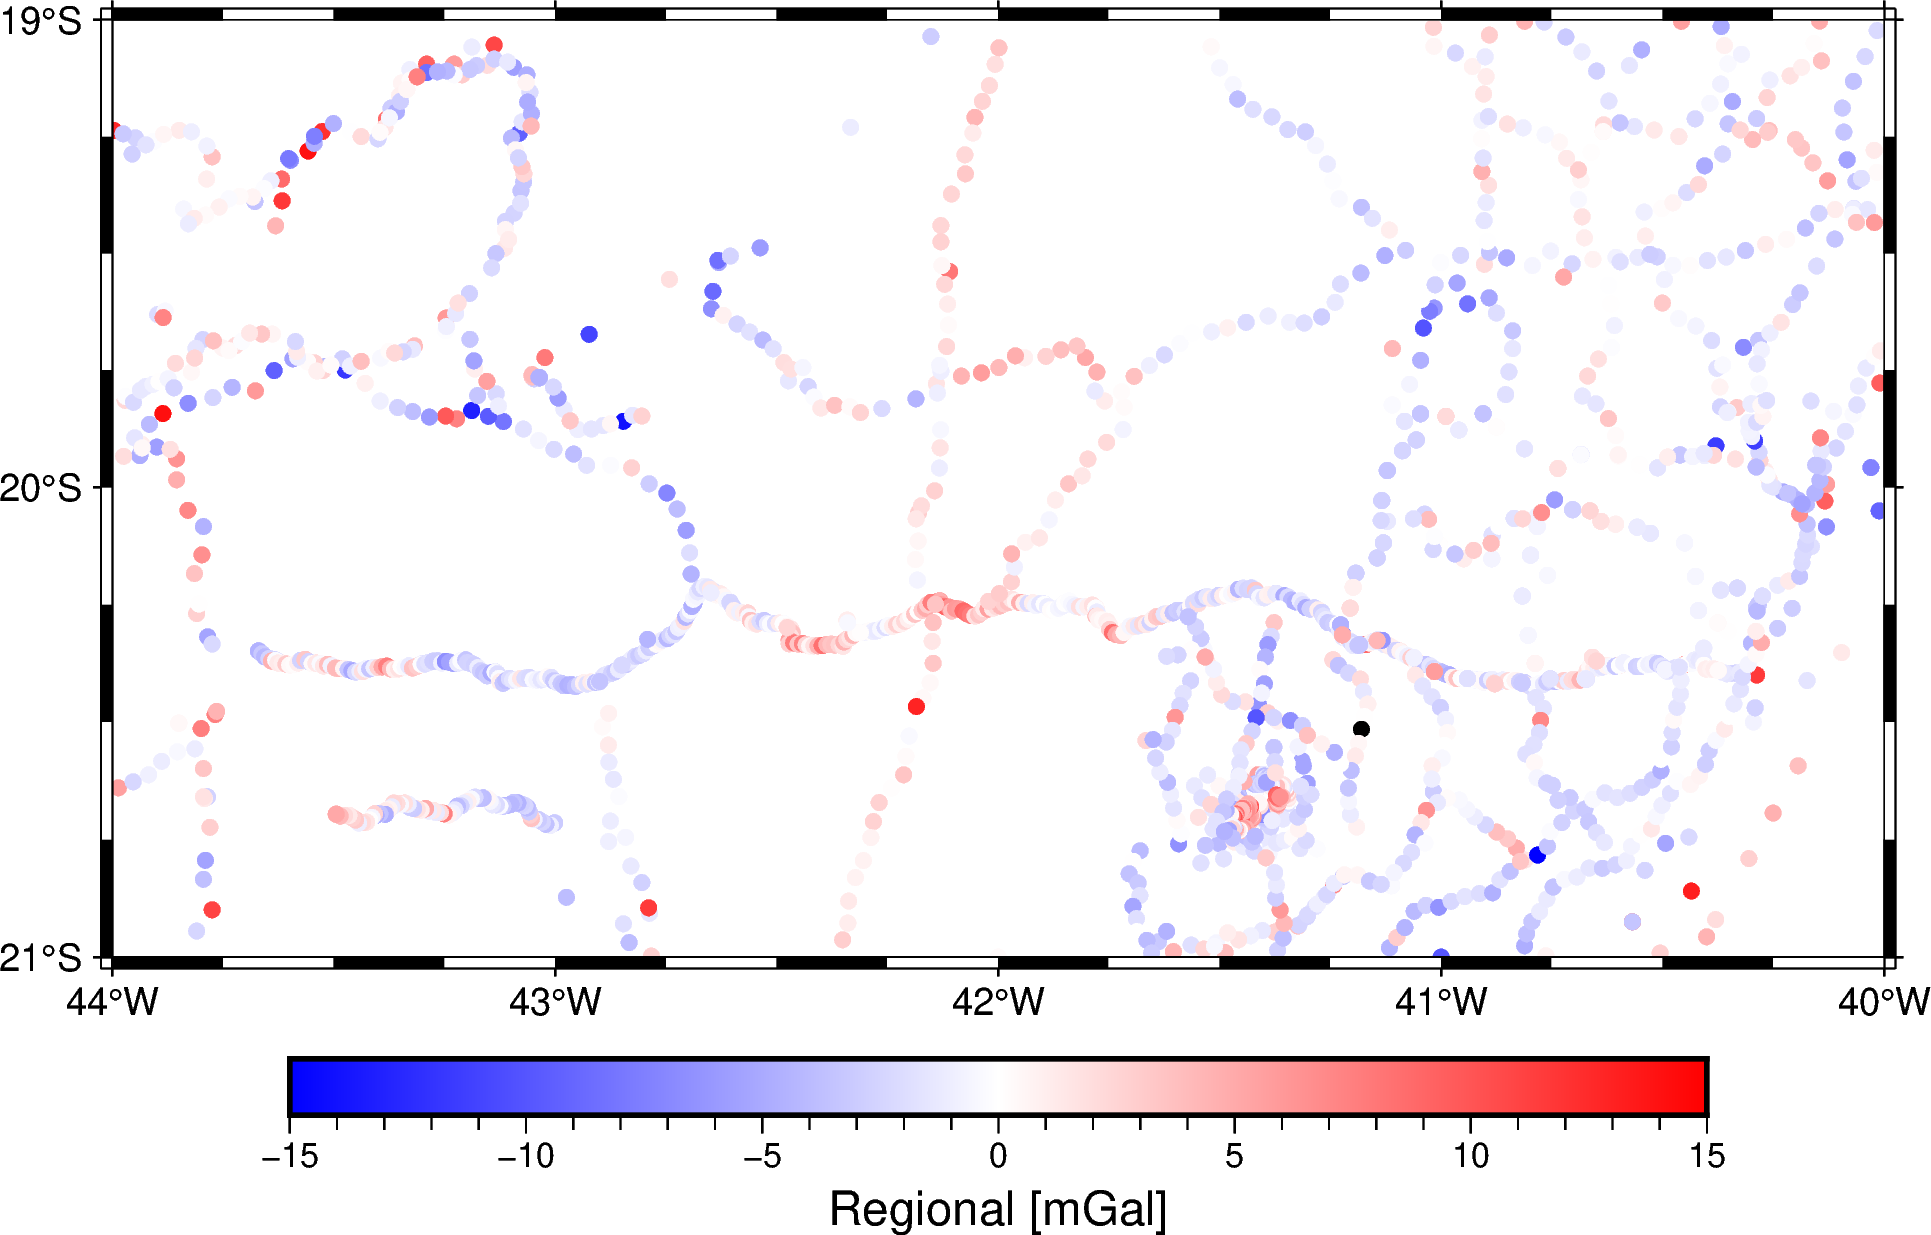

In [42]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.obs_minus_low_freq_residual)
pygmt.makecpt(cmap="polar", series=[-15, 15])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.obs_minus_low_freq_residual,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Regional [mGal]"')
fig.show()

# Interpola

In [46]:
eqs = hm.EquivalentSources(damping=1, depth=1e3)
eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m), data.obs_minus_low_freq_residual)

/home/gelson/anaconda3/envs/fatiando/lib/python3.10/site-packages/verde/base/least_squares.py:68: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr.fit(jacobian, data.ravel(), sample_weight=weights)


EquivalentSources(damping=1, depth=1000.0)

In [47]:
high_freq_residual_grid = eqs.grid(
    coordinates=vd.grid_coordinates(region, spacing= 4 / 3600, extra_coords=3e3),
    data_names="gravity_residual",
    dims=("latitude", "longitude"),
    projection=projection,
)
high_freq_residual_grid

<xarray.Dataset>
Dimensions:           (latitude: 1801, longitude: 3601)
Coordinates:
  * longitude         (longitude) float64 -44.0 -44.0 -44.0 ... -40.0 -40.0
  * latitude          (latitude) float64 -21.0 -21.0 -21.0 ... -19.0 -19.0 -19.0
    upward            (latitude, longitude) float64 3e+03 3e+03 ... 3e+03 3e+03
Data variables:
    gravity_residual  (latitude, longitude) float64 0.1556 0.1558 ... -0.414
Attributes:
    metadata:  Generated by EquivalentSources(damping=1, depth=1000.0)

/tmp/ipykernel_36569/2239116498.py:12: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


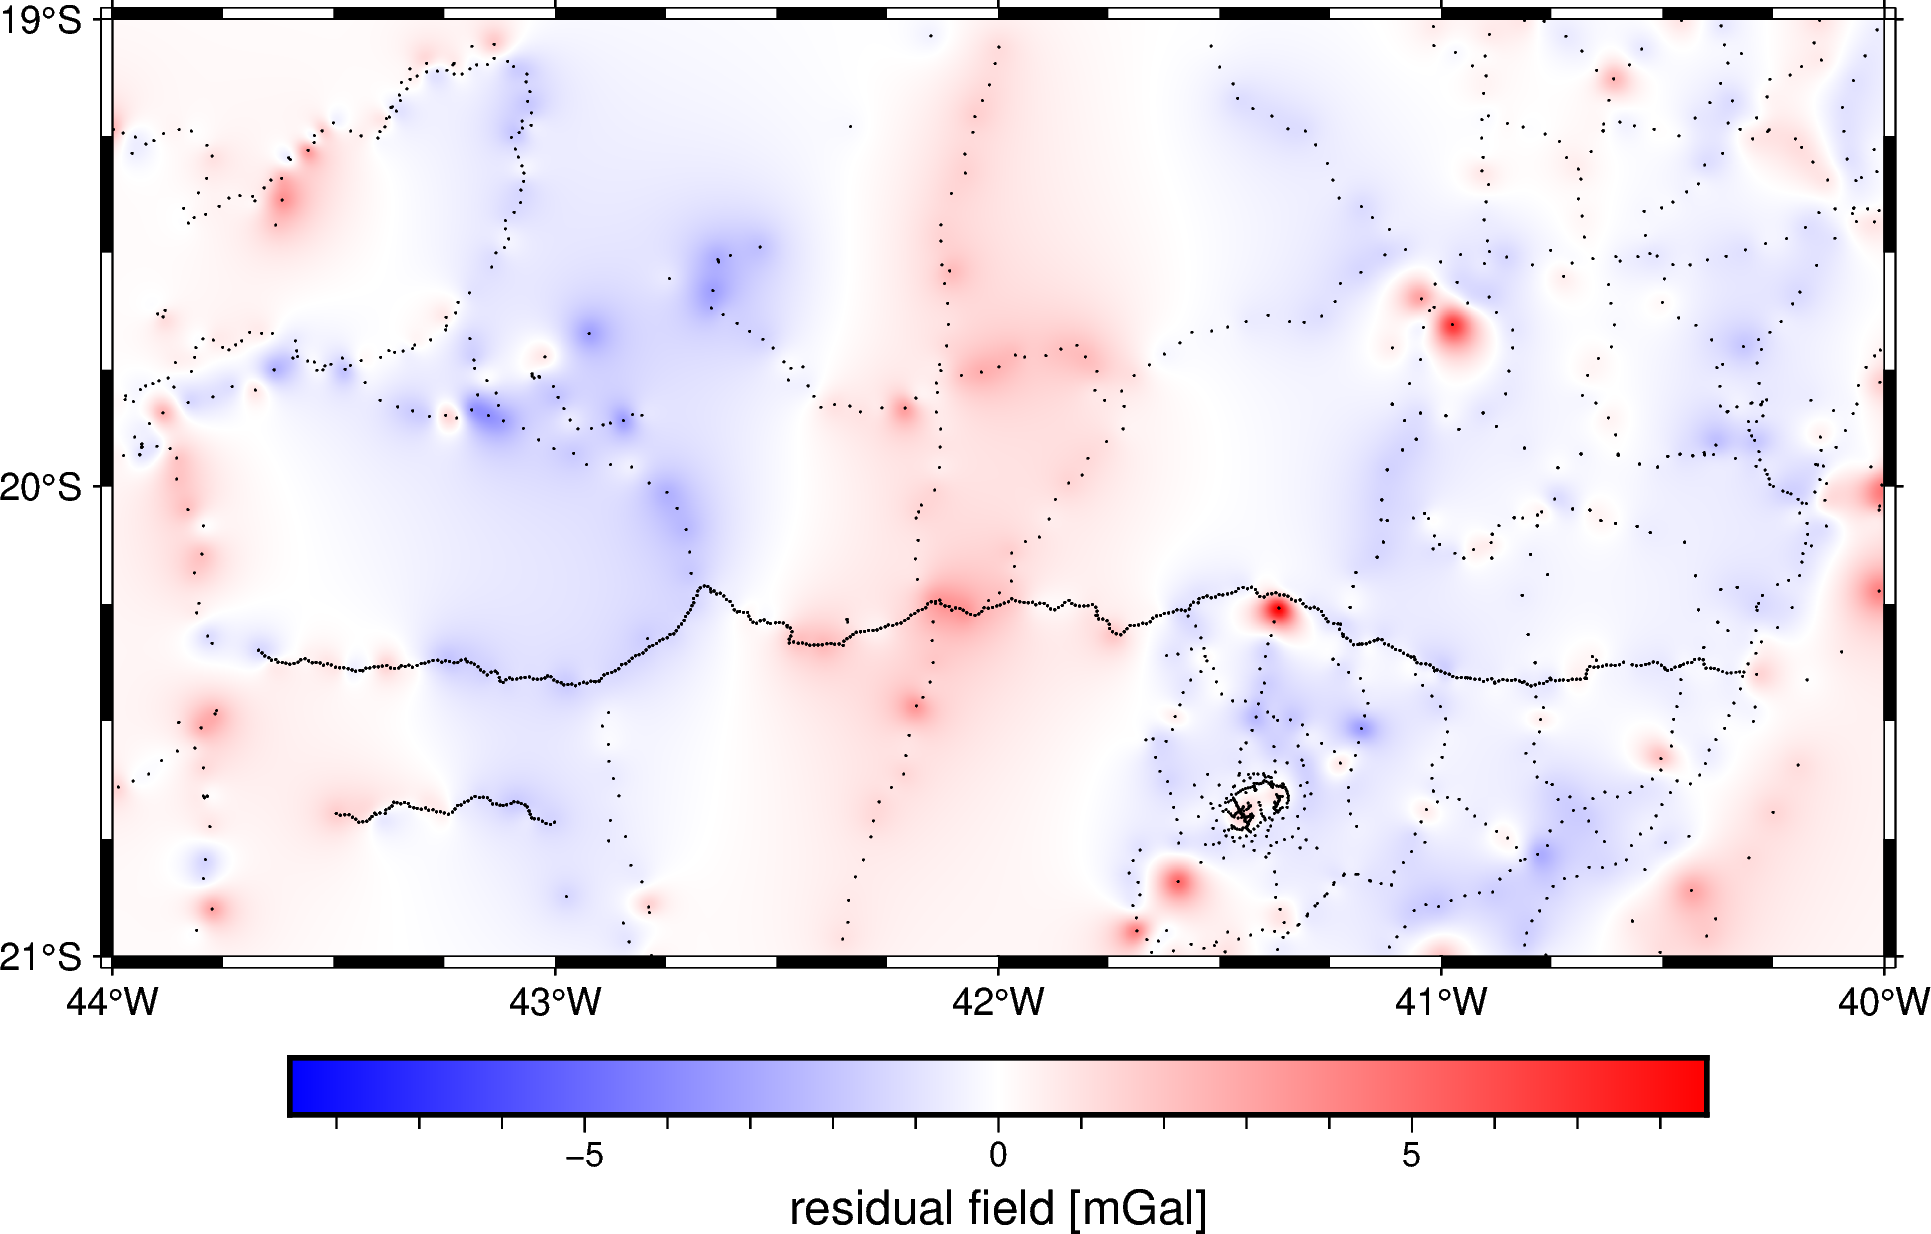

In [48]:
fig = pygmt.Figure()
scale = vd.maxabs(high_freq_residual_grid.gravity_residual)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    high_freq_residual_grid.gravity_residual,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    # region=(-41.5572222222, -41.2802777778, -20.8008333333, -20.5533333333)
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.02c",
    color="black",
    
)
fig.show()

In [49]:
grid_final = high_freq_residual_grid + residual_grid

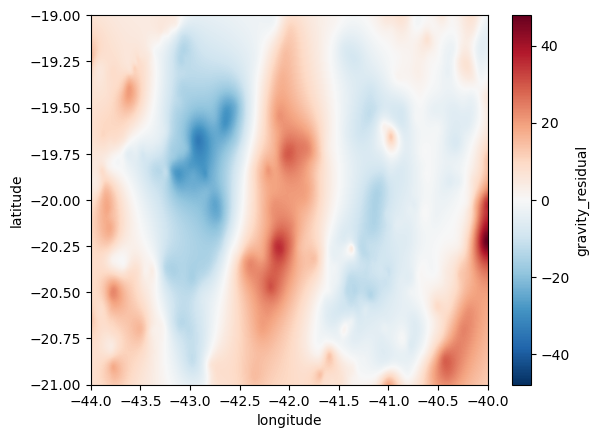

In [50]:
grid_final.gravity_residual.plot()

/tmp/ipykernel_36569/116179035.py:12: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


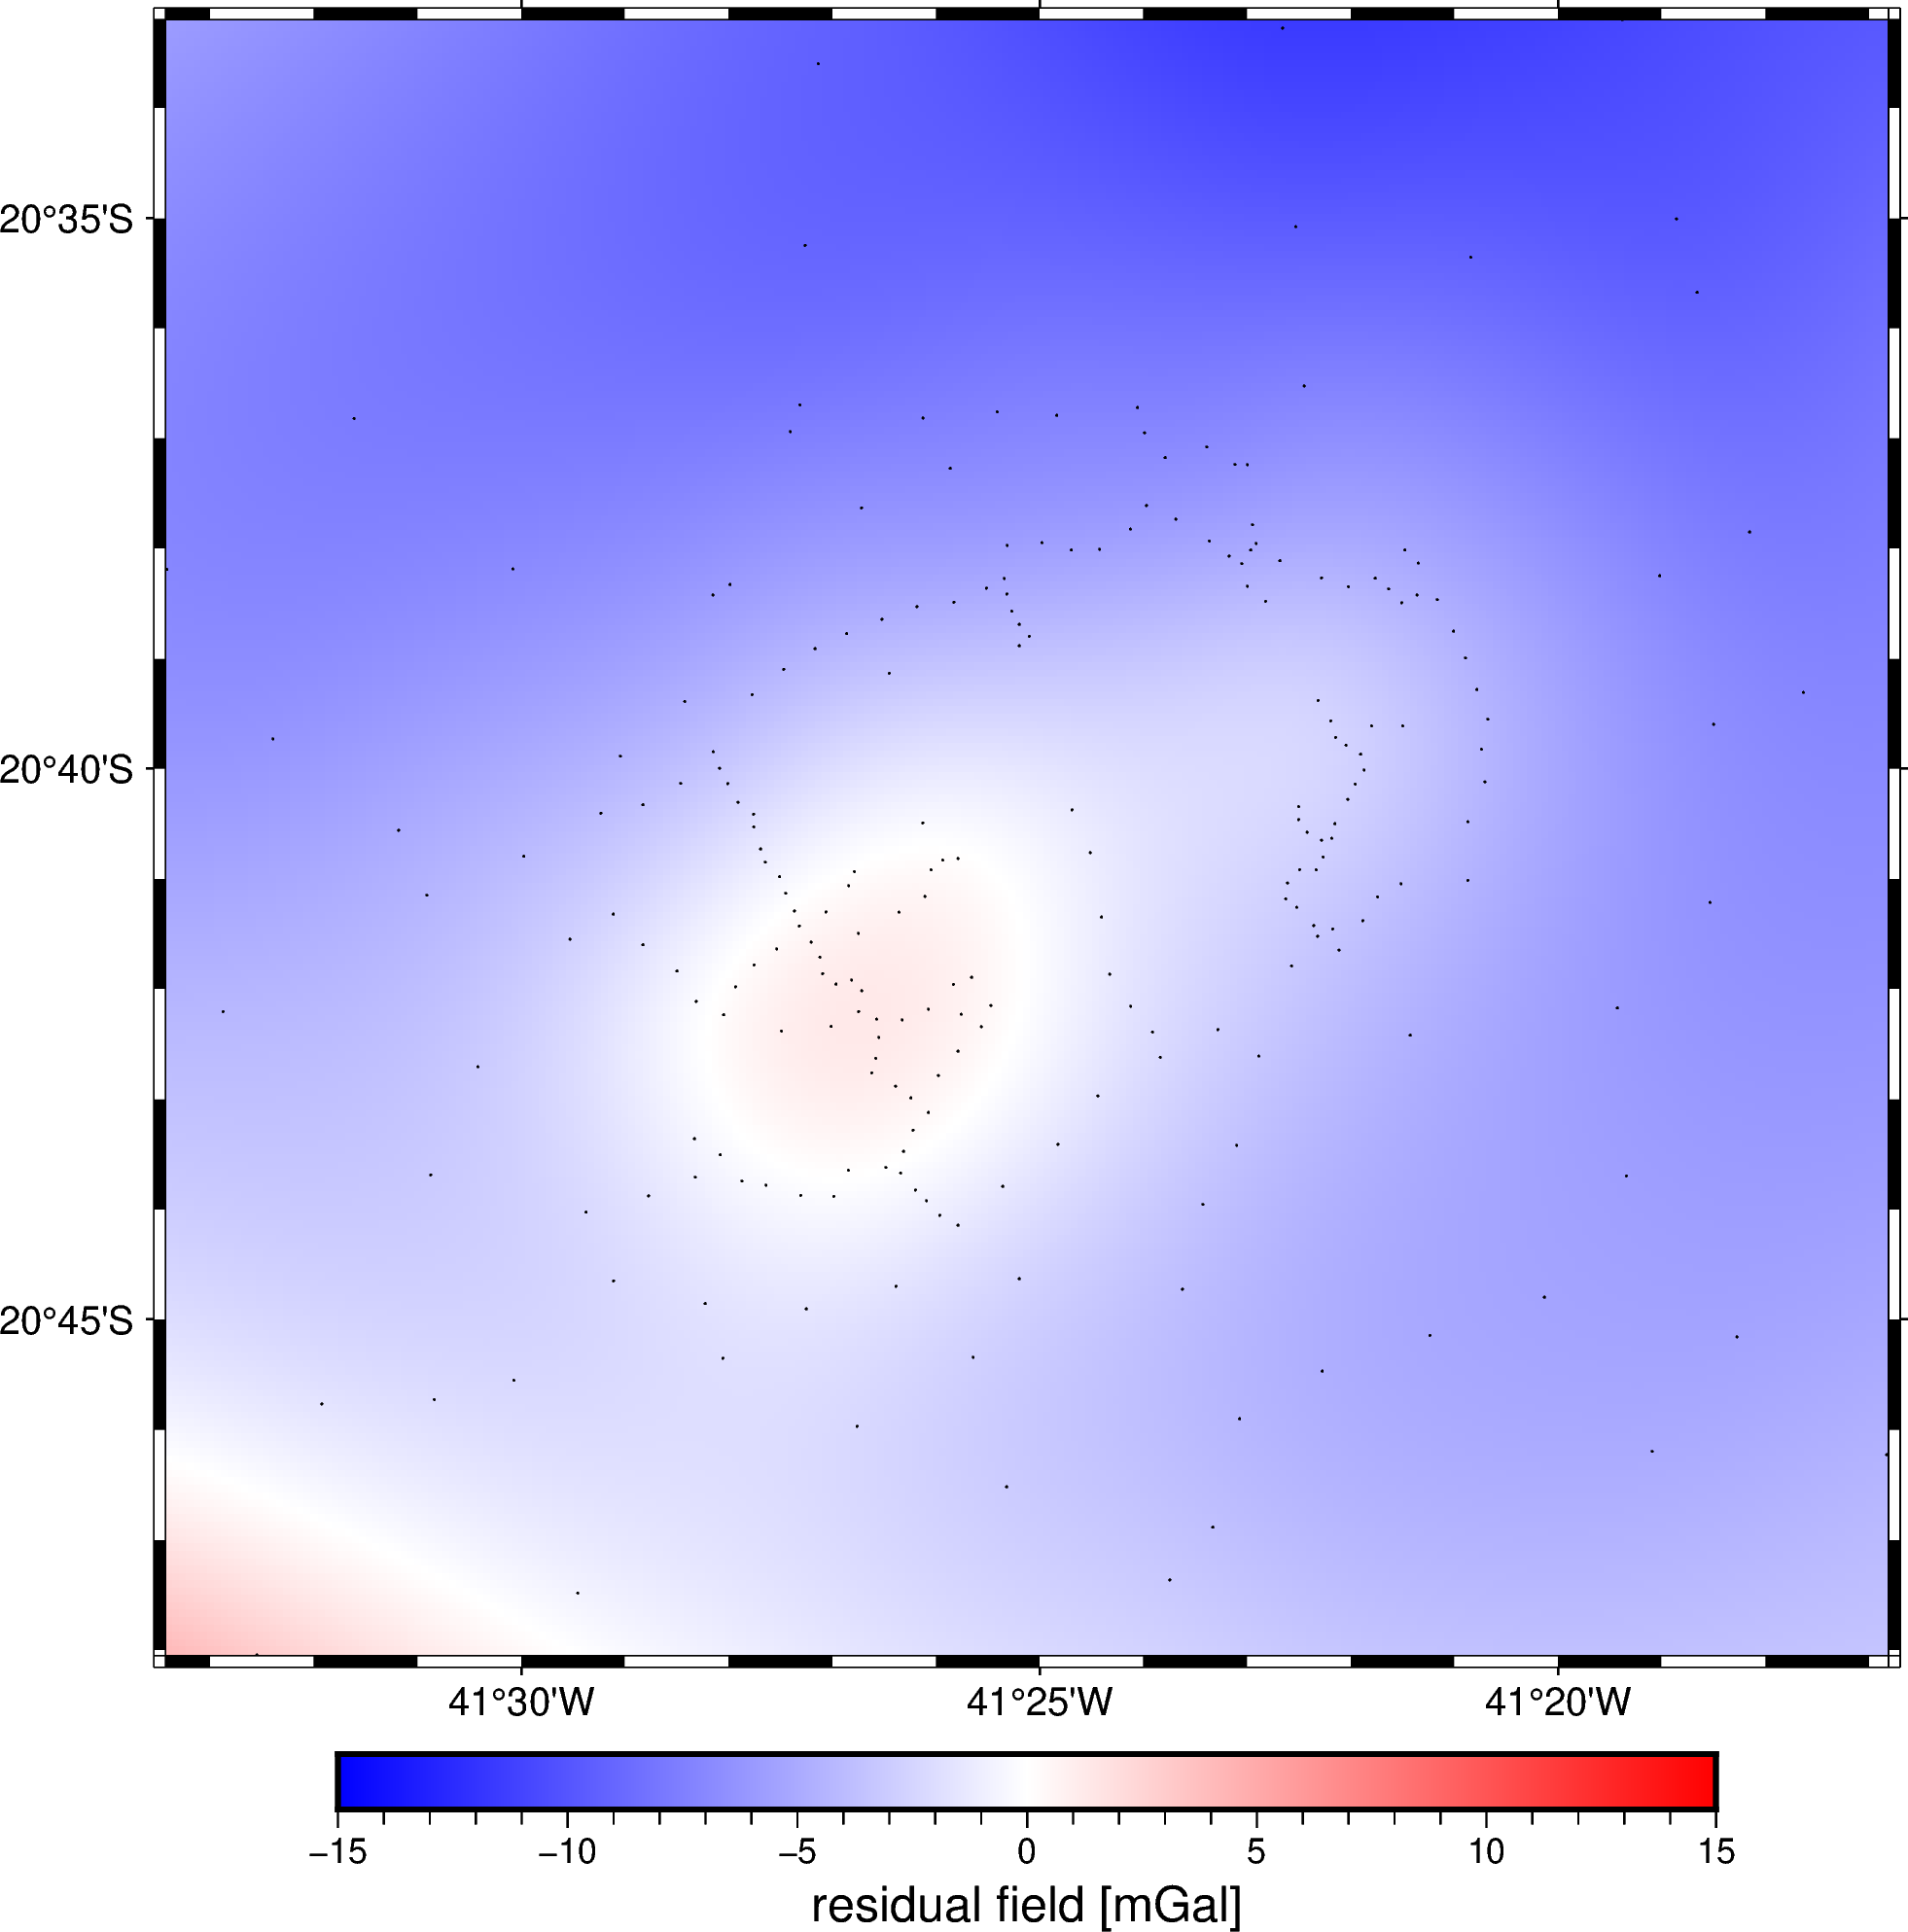

In [54]:
fig = pygmt.Figure()
scale = vd.maxabs(grid_final.gravity_residual)
pygmt.makecpt(cmap="polar", series=[-15, 15], no_bg=True)
fig.grdimage(
    grid_final.gravity_residual,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    region=(-41.5572222222, -41.2802777778, -20.8008333333, -20.5533333333)
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.02c",
    color="black",
    
)
fig.show()